# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az

df = pd.read_csv("results/data_stats.csv", index_col=0)
df["region_name_id"] = pd.factorize(df["region_name"])[0]
print(f"N = {df.shape[0]}")
df.sample(5)

N = 3228


year       region_name  population_interpolated         N_est  \
1453  1754             Italy                  15.3200   7796.357193   
3217  1830    United Kingdom                  16.9000  10982.220405   
2906  1519    United Kingdom                   4.3830    704.318809   
2421  1682  Nordic countries                   2.2420   1761.781245   
2782  1395    United Kingdom                   2.9675    147.731668   

             lower         upper   score  score_cap   lower_cap   N_est_cap  \
1453   7131.774366   8482.569487   383.2  24.978228  465.175966  508.549348   
3217  10420.581190  11569.327469  1448.0  85.680473  616.602437  649.835527   
2906    589.806211    827.652446    48.9  11.150025  134.479515  160.590104   
2421   1534.782780   2007.259342    89.0  39.748174  685.349949  786.726812   
2782    110.358085    190.713108     9.5   3.237516   37.611846   50.342864   

       upper_cap  gdp_per_capita  inclusive  restricted  region_name_id  
1453  553.324799            2895          1           1               4  
3217  684.575590            3550          1           1               9  
2906  188.711983            1784          1           1               9  
2421  896.359521            1867          1           1               7  
2782   64.983236            1723          1           1               9

We have GDP data for the following 10 regions:

In [2]:
df["region_name"].value_counts()

United Kingdom      590
Nordic countries    541
France              532
Italy               532
Low countries       487
Eastern Europe      423
Spain                58
Chinese world        46
Japan                12
German world          7
Name: region_name, dtype: int64

We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

In [3]:
# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])
df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])
df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df.sample(5)

year     region_name  population_interpolated         N_est  \
1668  1464   Low countries                    1.880    193.232356   
455   1827  Eastern Europe                   35.325  41405.021811   
952   1762          France                   25.200   5985.840814   
36    1760   Chinese world                  265.000    509.297638   
2911  1524  United Kingdom                    4.418    662.632548   

             lower         upper   score  score_cap    lower_cap    N_est_cap  \
1668    161.570036    227.983924    24.6  13.120393    86.250711   103.162038   
455   38901.597759  43999.929399  2058.8  58.467222  1105.208946  1176.271613   
952    5684.186809   6291.160391   746.4  29.668923   225.962549   237.957984   
36      416.612884    609.793881    51.0   0.192453     1.572124     1.921878   
2911    556.523846    776.572674    49.4  11.185634   126.104704   150.152224   

      ...  score_log  score_cap_log  N_est_log  N_est_cap_log  score_log_std  \
1668  ...   3.202746       2.574168   5.263893       4.636301       0.740453   
455   ...   7.629879       4.068466  10.631157       7.070105       1.763976   
952   ...   6.615262       3.390100   8.697152       5.472094       1.529403   
36    ...   3.931826      -1.647904   6.233033       0.653303       0.909011   
2911  ...   3.899950       2.414630   6.496221       5.011650       0.901642   

      score_cap_log_std  N_est_log_std  N_est_cap_log_std   log_gdp  \
1668           1.068317       0.778720           0.957132  7.765145   
455            1.688472       1.572733           1.459574  6.825460   
952            1.406941       1.286624           1.129676  7.424762   
36            -0.683904       0.922091           0.134870  6.929517   
2911           1.002106       0.961026           1.034620  7.531552   

      log_gdp_std  
1668     1.034002  
455      0.908874  
952      0.988677  
36       0.922730  
2911     1.002897  

[5 rows x 26 columns]

The distribution of the logged GDP values is clearly trimodal:

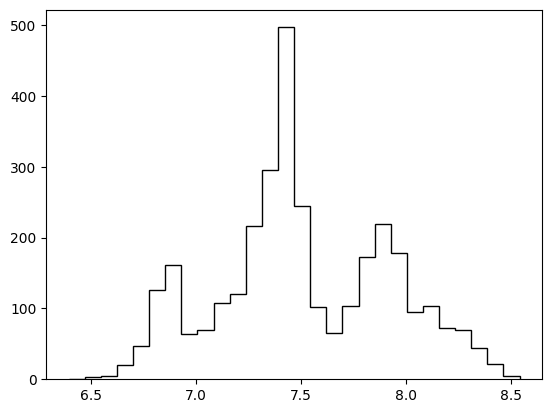

In [4]:
import matplotlib.pyplot as plt

plt.hist(df["log_gdp"].values, histtype="step", color="k", bins="fd");

We observe an intriguing trimodal structure. It was suggested by Charles that this might be due to "the fact that the Maddison data always tend to have an estimation for a region at date year=1 and then jump up to over year=1000". Filtering these instances, doesn't seem to alter the trimodal structure, however:

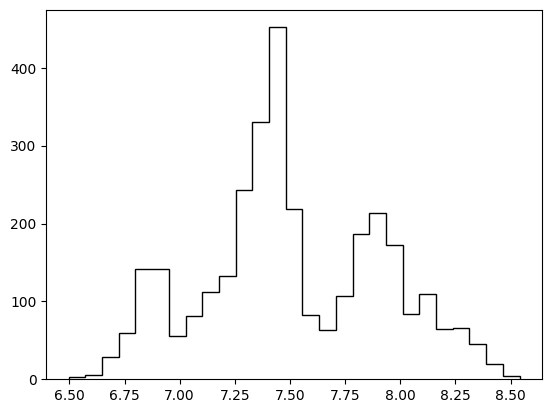

In [5]:
plt.hist(df.loc[df["year"] >= 1000, "log_gdp"].values, histtype="step", color="k", bins="fd");

The trimodality of the data is somewhat hidden when plotting against the unnormalized score and bias-corrected score. However, after log transformation, the structure becomes visible again:

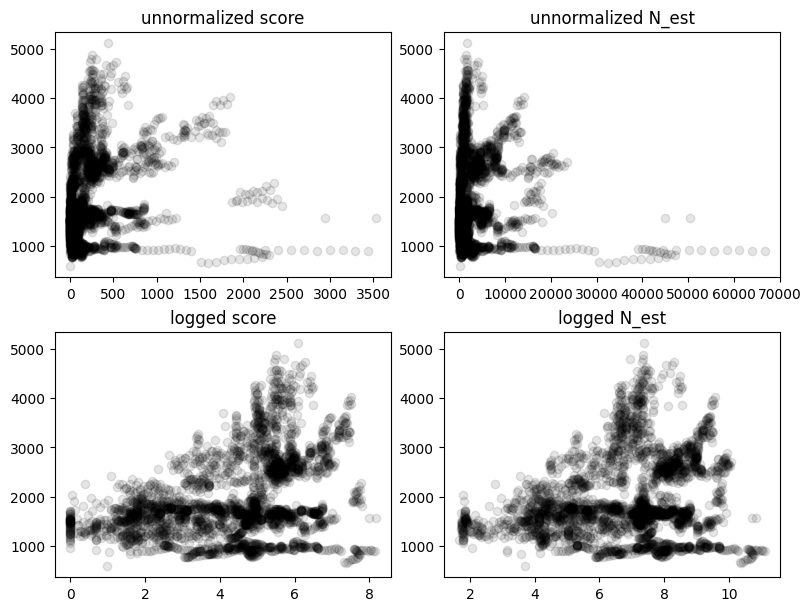

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), constrained_layout=True)
axes = axes.flatten()

axes[0].scatter(df["score"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[0].set_title("unnormalized score")

axes[1].scatter(df["N_est"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[1].set_title("unnormalized N_est")

axes[2].scatter(df["score_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[2].set_title("logged score")

axes[3].scatter(df["N_est_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[3].set_title("logged N_est");

## Regression Analysis: Setting a Baseline

In our attempt to model the relationship between per capita GDP and cultural production, we utilize linear regression models. By progressively developing more intricate models, we evaluate them via approximate leave-one-out cross-validation (LOO). Initially, we establish a global relationship model that doesn't account for any regional differentiation. The model is specified as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In this model, $\alpha$ stands for the intercept and $\beta$ denotes the coefficient of the production score.

In [7]:
models = {}

The model is easily translated to Bambi with:

In [8]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score = bmb.Model(
    f"log_gdp_std ~ score_log_std", df, family="gaussian", priors=priors)

The model graph looks as follows:

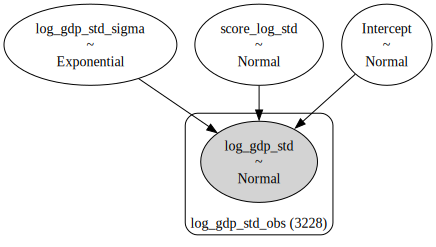

In [9]:
m_score.build()
m_score.graph()

Since this is a relatively simple model, we tune the sampler for 1000 timesteps and draw 1000 samples from the posterior:

In [10]:
fit_score = m_score.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ score_log_std"] = fit_score

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


A quick summary of the model wth ArViz indicates that globally, the cultural production score has small yet pronounced effect:

In [11]:
az.summary(models["gdp ~ score_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.957  0.002   0.953    0.962        0.0      0.0   
score_log_std      0.043  0.002   0.038    0.047        0.0      0.0   
log_gdp_std_sigma  0.052  0.001   0.050    0.053        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            6854.0    3365.0    1.0  
score_log_std        6768.0    3323.0    1.0  
log_gdp_std_sigma    5740.0    2762.0    1.0

However, the model fit is not particularly good. To further examine this, we conduct a posterior predictive check where we plot the estimated posterior against the observed GDP distribution. Evidently, the model falls short in fitting the trimodal structure of the data:

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


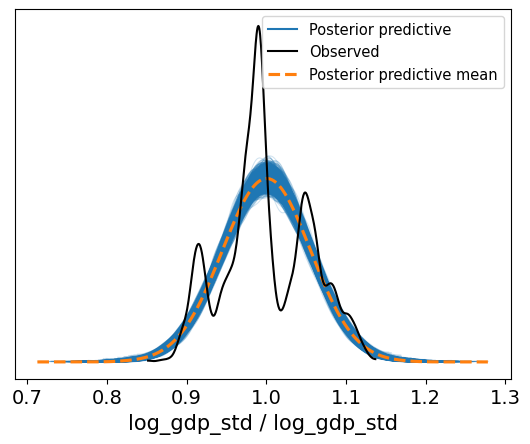

In [12]:
m_score.predict(fit_score, kind="pps")
az.plot_ppc(fit_score);

When we map the predictive posterior slopes against the empirical data in a scatter plot, it reaffirms our previous observation: the model is inadequate in accurately characterizing the data:

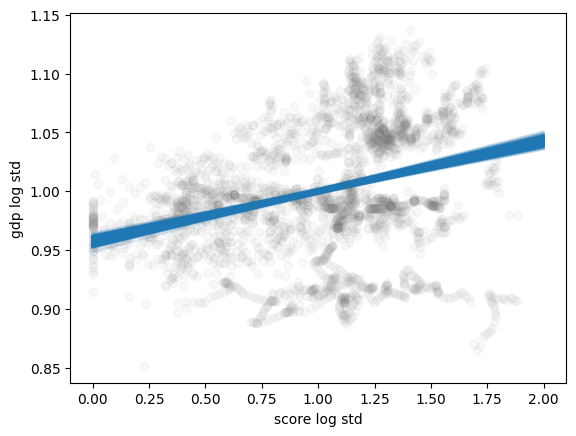

In [13]:
score_log_std_new = np.linspace(0, 2, num=200)
m_score.predict(fit_score, data=pd.DataFrame({"score_log_std": score_log_std_new}))
gdp = fit_score.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(score_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["score_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="score log std", ylabel="gdp log std");

We juxtapose this model with another where we employ the bias-corrected cultural production score as opposed to the unnormalized score. While the model specification remains consistent, its implementation unfolds as follows:

In [14]:
m_est = bmb.Model(
    f"log_gdp_std ~ N_est_log_std", df, family="gaussian", priors=priors)
fit_est = m_est.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ N_est_log_std"] = fit_est

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Similar to the previous analysis, a cursory analysis of the new model seems to suggest a slightly weaker but still positive correlation between the cultural production score and GDP:

In [15]:
az.summary(models["gdp ~ N_est_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.967  0.004   0.961    0.974        0.0      0.0   
N_est_log_std      0.033  0.003   0.026    0.039        0.0      0.0   
log_gdp_std_sigma  0.054  0.001   0.052    0.055        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            6617.0    3338.0    1.0  
N_est_log_std        6613.0    3379.0    1.0  
log_gdp_std_sigma    5655.0    3084.0    1.0

This relationship is visualized in the following graph:

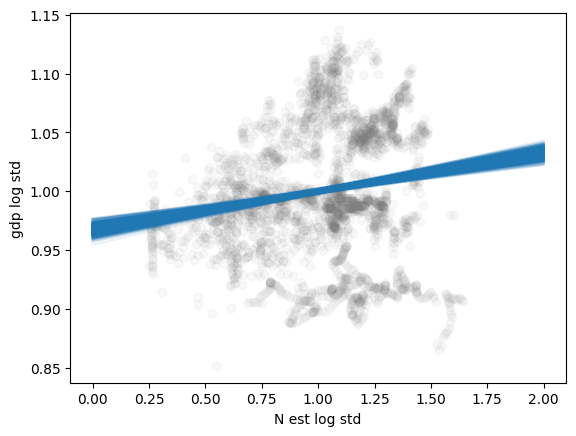

In [16]:
N_est_log_std_new = np.linspace(0, 2, num=200)
m_est.predict(fit_est, data=pd.DataFrame({"N_est_log_std": N_est_log_std_new}))
gdp = fit_est.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(N_est_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["N_est_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="N est log std", ylabel="gdp log std");

However, as indicated by the posterior predictive check, the model fit continues to disappointingly underperform:

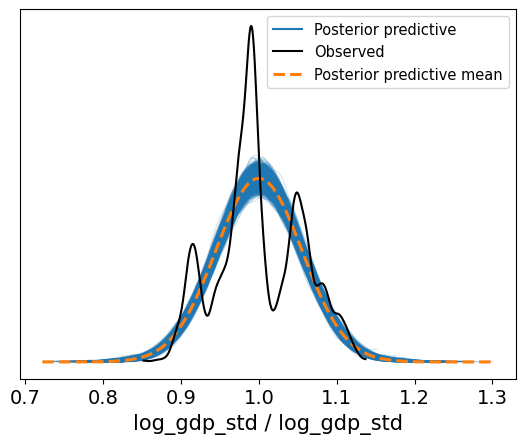

In [17]:
m_est.predict(fit_est, kind="pps")
az.plot_ppc(fit_est);

We utilize WAIC (Widely Applicable Information Criterion) or LOO to compare these models. This evaluation shows that the model incorporating the bias-corrected production variable does not perform better than one using the unnormalized variable. Nevertheless, as previously observed, both models exhibit subpar performance, suggesting caution in drawing any conclusions from this comparison. Overall, there appears evidence for a mildly positive relationship between the variables.

In [18]:
waic_compare = az.compare(models, ic='WAIC')
waic_compare

rank    elpd_waic    p_waic   elpd_diff        weight  \
gdp ~ score_log_std     0  4991.715569  2.721372    0.000000  1.000000e+00   
gdp ~ N_est_log_std     1  4862.266855  2.637876  129.448714  1.909086e-10   

                            se       dse  warning scale  
gdp ~ score_log_std  37.696530  0.000000    False   log  
gdp ~ N_est_log_std  35.932585  8.788343    False   log

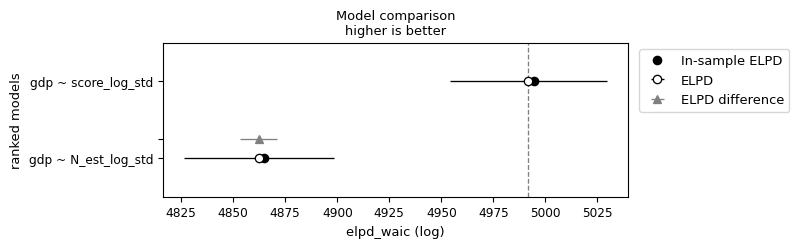

In [19]:
az.plot_compare(waic_compare, insample_dev=True);

## Hierarchical Linear Models

We now progress to a more nuanced analysis that leverages the inherent structure of our data, employing hierarchical linear models. Initially, we implement a rudimentary hierarchical model that only features varying intercepts for regions. This approach models each region as a distinct distribution, each contributing to the global intercept. The specification of the model is as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]}\\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In [20]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_vi = bmb.Model(
    "log_gdp_std ~ 1 + (1|region_name)", df, family="gaussian", noncentered=True, priors=priors)
m_vi

       Formula: log_gdp_std ~ 1 + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

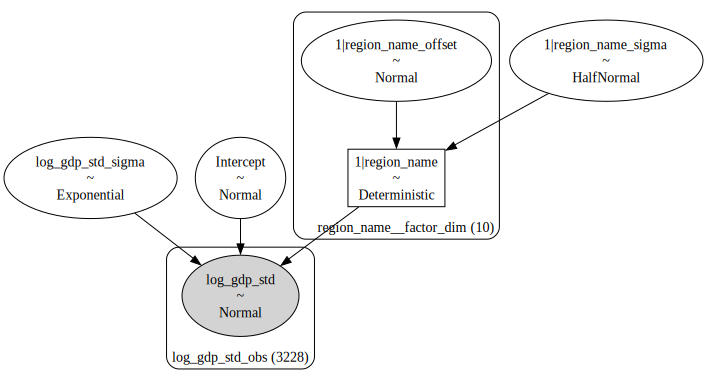

In [21]:
m_vi.build()
m_vi.graph()

The complexity of this model increases slightly, particularly due to the limited data points available for certain regions. Consequently, it's advisable to generate more posterior samples than in the previous models and proceed with a degree of caution while exploring the posterior during the sampling process:

In [22]:
m_vi_fit = m_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,  # more cautious exploration of the posterior
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ (1|region_name)"] = m_vi_fit
az.summary(m_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 76 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.981  0.019   0.945    1.017      0.001   
log_gdp_std_sigma                0.026  0.000   0.026    0.027      0.000   
1|region_name_sigma              0.059  0.017   0.034    0.090      0.000   
1|region_name[Chinese world]    -0.037  0.019  -0.073   -0.001      0.001   
1|region_name[Eastern Europe]   -0.067  0.019  -0.102   -0.031      0.001   
1|region_name[France]            0.008  0.019  -0.027    0.045      0.001   
1|region_name[German world]     -0.002  0.021  -0.042    0.037      0.001   
1|region_name[Italy]             0.073  0.019   0.035    0.107      0.001   
1|region_name[Japan]            -0.059  0.020  -0.097   -0.022      0.001   
1|region_name[Low countries]     0.084  0.019   0.049    0.121      0.001   
1|region_name[Nordic countries] -0.003  0.019  -0.038    0.033      0.001   
1|region_name[Spain]            -0.014  0.019  -0.050    0.022      0.001   
1|region_name[United Kingdom]    0.019  0.019  -0.019    0.053      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1184.0    1811.0    1.0  
log_gdp_std_sigma                    0.0    4397.0    3952.0    1.0  
1|region_name_sigma                  0.0    1389.0    2137.0    1.0  
1|region_name[Chinese world]         0.0    1208.0    1971.0    1.0  
1|region_name[Eastern Europe]        0.0    1196.0    1858.0    1.0  
1|region_name[France]                0.0    1191.0    1839.0    1.0  
1|region_name[German world]          0.0    1339.0    2131.0    1.0  
1|region_name[Italy]                 0.0    1183.0    1806.0    1.0  
1|region_name[Japan]                 0.0    1331.0    2289.0    1.0  
1|region_name[Low countries]         0.0    1186.0    1892.0    1.0  
1|region_name[Nordic countries]      0.0    1188.0    1840.0    1.0  
1|region_name[Spain]                 0.0    1187.0    1871.0    1.0  
1|region_name[United Kingdom]        0.0    1187.0    1848.0    1.0

The sampling process appears to be effective, characterized by $\hat{r}$ scores hovering around 1 and a satisfactory effective sample size. Below, we provide a forest plot for the varying intercepts. Bear in mind that due to the construction of the model (non-centered), these intercepts should be interpreted as deviations from the global mean intercept, which is not displayed here.

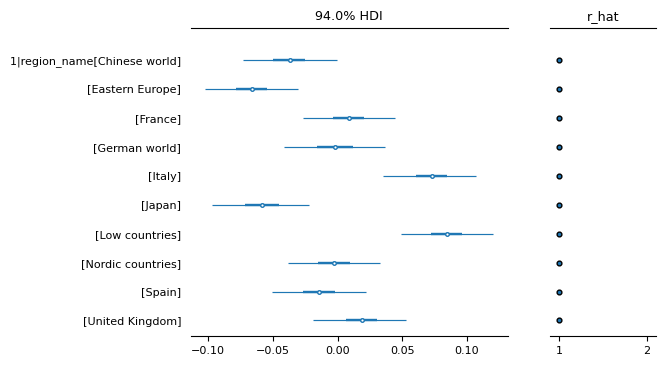

In [23]:
az.plot_forest(
    data=m_vi_fit, 
    figsize=(6, 4), 
    var_names=["1|region_name"], 
    r_hat=True, 
    combined=True, 
    textsize=8
);

Merely by incorporating the hierarchical levels associated with regions, we notice a significant improvement in the model fit, as illustrated in the subsequent posterior predictive check plot:

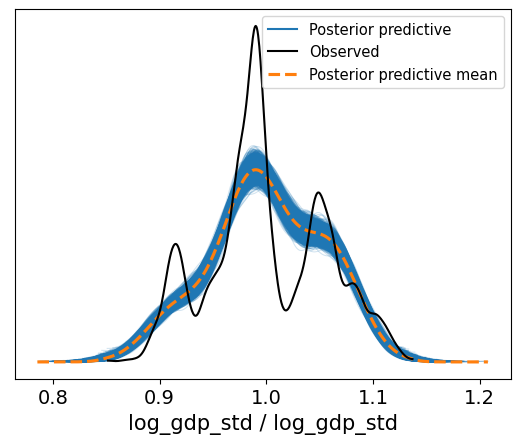

In [24]:
m_vi.predict(m_vi_fit, kind="pps")
az.plot_ppc(m_vi_fit);

### Varying Regions with Global Cultural Production Relationship

It thus seems that allowing variation in GDP per region is useful. We continue experimenting, adding the cultural production both regular and corrected to the model. The model description then becomes:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} \beta x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

Note that this is essentially the model proposed in the current version of the paper without the variable time. However, including time as a linear predictor will not change the most important lessons of the models below.

In [25]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vi = bmb.Model(
    "log_gdp_std ~ score_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_vi

       Formula: log_gdp_std ~ score_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

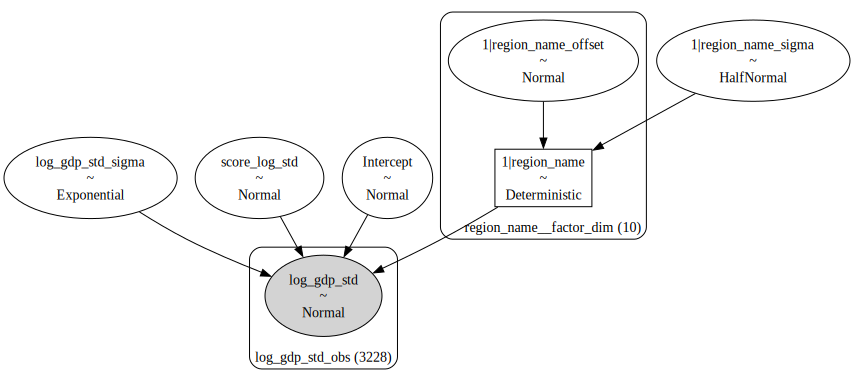

In [26]:
m_score_vi.build()
m_score_vi.graph()

In [27]:
m_score_vi_fit = m_score_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_log_std + (1|region_name)"] = m_score_vi_fit
az.summary(m_score_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 106 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.947  0.019   0.912    0.982      0.001   
score_log_std                    0.035  0.001   0.033    0.037      0.000   
log_gdp_std_sigma                0.023  0.000   0.022    0.024      0.000   
1|region_name_sigma              0.056  0.016   0.032    0.085      0.000   
1|region_name[Chinese world]    -0.028  0.019  -0.063    0.008      0.001   
1|region_name[Eastern Europe]   -0.072  0.019  -0.108   -0.038      0.001   
1|region_name[France]            0.006  0.019  -0.029    0.041      0.001   
1|region_name[German world]     -0.023  0.020  -0.062    0.015      0.001   
1|region_name[Italy]             0.064  0.019   0.030    0.100      0.001   
1|region_name[Japan]            -0.048  0.019  -0.084   -0.010      0.001   
1|region_name[Low countries]     0.081  0.019   0.046    0.116      0.001   
1|region_name[Nordic countries]  0.007  0.019  -0.028    0.042      0.001   
1|region_name[Spain]            -0.013  0.019  -0.047    0.023      0.001   
1|region_name[United Kingdom]    0.020  0.019  -0.014    0.056      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1350.0    1955.0    1.0  
score_log_std                        0.0    6563.0    4906.0    1.0  
log_gdp_std_sigma                    0.0    5614.0    4649.0    1.0  
1|region_name_sigma                  0.0    1637.0    2241.0    1.0  
1|region_name[Chinese world]         0.0    1380.0    2121.0    1.0  
1|region_name[Eastern Europe]        0.0    1345.0    2017.0    1.0  
1|region_name[France]                0.0    1345.0    1985.0    1.0  
1|region_name[German world]          0.0    1537.0    2365.0    1.0  
1|region_name[Italy]                 0.0    1349.0    1964.0    1.0  
1|region_name[Japan]                 0.0    1484.0    2294.0    1.0  
1|region_name[Low countries]         0.0    1348.0    2009.0    1.0  
1|region_name[Nordic countries]      0.0    1347.0    2005.0    1.0  
1|region_name[Spain]                 0.0    1370.0    1973.0    1.0  
1|region_name[United Kingdom]        0.0    1350.0    1967.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.035 CI [0.032, 0.037]). It seems that the model fit has experienced a slight enhancement

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


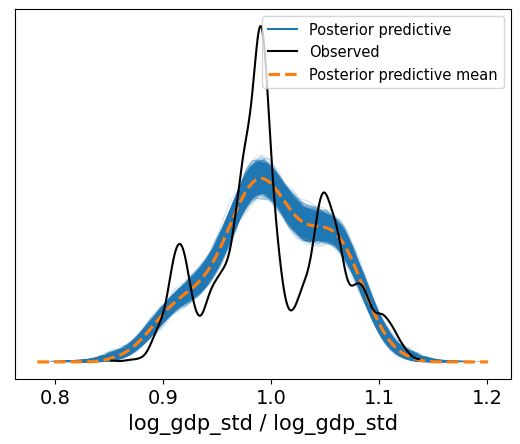

In [28]:
m_score_vi.predict(m_score_vi_fit, kind="pps")
az.plot_ppc(m_score_vi_fit);

Nevertheless, plotting the predictions against the observed data for each region provides more insightful information. This is depicted in the plot below, wherein it's evident that a global predictor of cultural production falls short in fitting the data accurately. Many regions, such as the Low Countries, the Chinese World, or Portugal, exhibit significant residuals, leaving a considerable amount of variation unexplained. Crucially, by assuming the relationship to be exclusively global, we imply it can only be unidirectional --- an assumption that, as we'll soon discover, may not necessarily hold true.

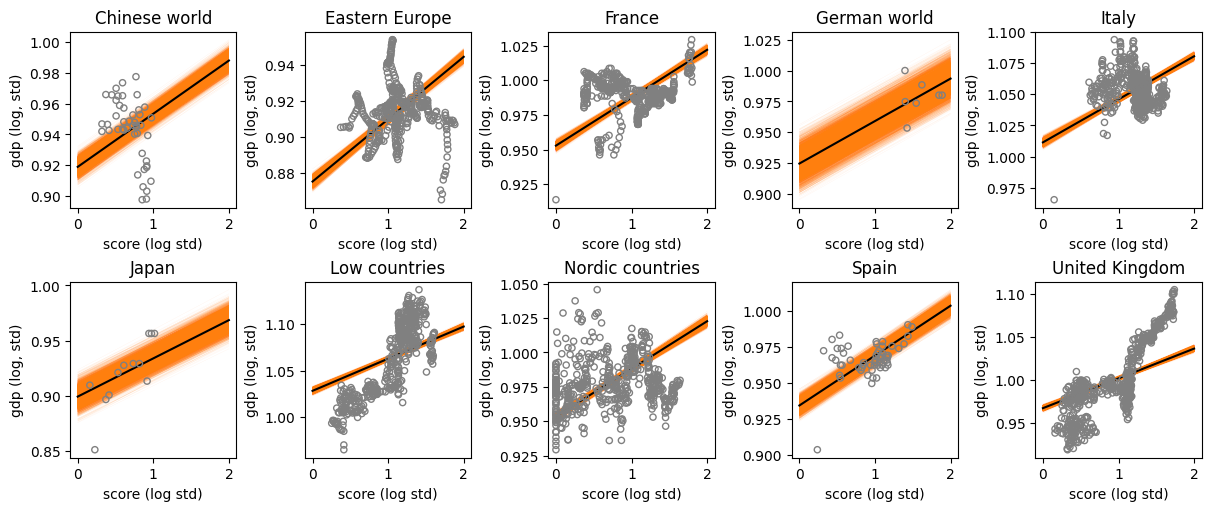

In [29]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

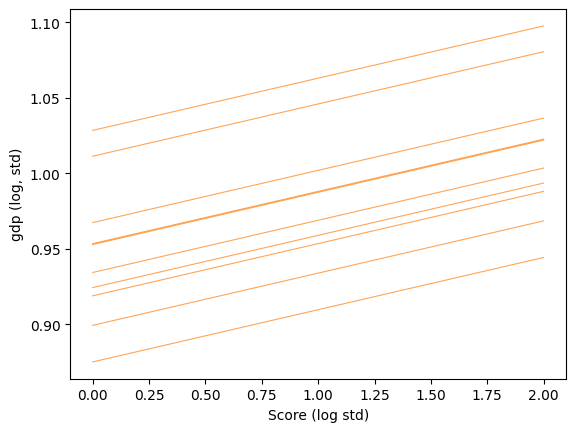

In [30]:
posterior = az.extract(m_score_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [31]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vi = bmb.Model(
    "log_gdp_std ~ N_est_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_vi

       Formula: log_gdp_std ~ N_est_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [32]:
m_est_vi_fit = m_est_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (1|region_name)"] = m_est_vi_fit
az.summary(m_est_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 87 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.937  0.019   0.900    0.973        0.0   
N_est_log_std                    0.044  0.002   0.041    0.047        0.0   
log_gdp_std_sigma                0.024  0.000   0.023    0.025        0.0   
1|region_name_sigma              0.058  0.017   0.032    0.089        0.0   
1|region_name[Chinese world]    -0.026  0.019  -0.063    0.010        0.0   
1|region_name[Eastern Europe]   -0.074  0.019  -0.109   -0.036        0.0   
1|region_name[France]            0.008  0.019  -0.027    0.045        0.0   
1|region_name[German world]     -0.022  0.020  -0.061    0.016        0.0   
1|region_name[Italy]             0.066  0.019   0.032    0.104        0.0   
1|region_name[Japan]            -0.048  0.020  -0.087   -0.011        0.0   
1|region_name[Low countries]     0.087  0.019   0.051    0.123        0.0   
1|region_name[Nordic countries]  0.005  0.019  -0.032    0.040        0.0   
1|region_name[Spain]            -0.013  0.019  -0.048    0.024        0.0   
1|region_name[United Kingdom]    0.021  0.019  -0.016    0.056        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1540.0    2199.0    1.0  
N_est_log_std                        0.0    5552.0    4259.0    1.0  
log_gdp_std_sigma                    0.0    5247.0    4376.0    1.0  
1|region_name_sigma                  0.0    1625.0    2693.0    1.0  
1|region_name[Chinese world]         0.0    1581.0    2516.0    1.0  
1|region_name[Eastern Europe]        0.0    1533.0    2236.0    1.0  
1|region_name[France]                0.0    1526.0    2218.0    1.0  
1|region_name[German world]          0.0    1803.0    2502.0    1.0  
1|region_name[Italy]                 0.0    1531.0    2225.0    1.0  
1|region_name[Japan]                 0.0    1645.0    2521.0    1.0  
1|region_name[Low countries]         0.0    1535.0    2170.0    1.0  
1|region_name[Nordic countries]      0.0    1526.0    2225.0    1.0  
1|region_name[Spain]                 0.0    1572.0    2329.0    1.0  
1|region_name[United Kingdom]        0.0    1517.0    2208.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

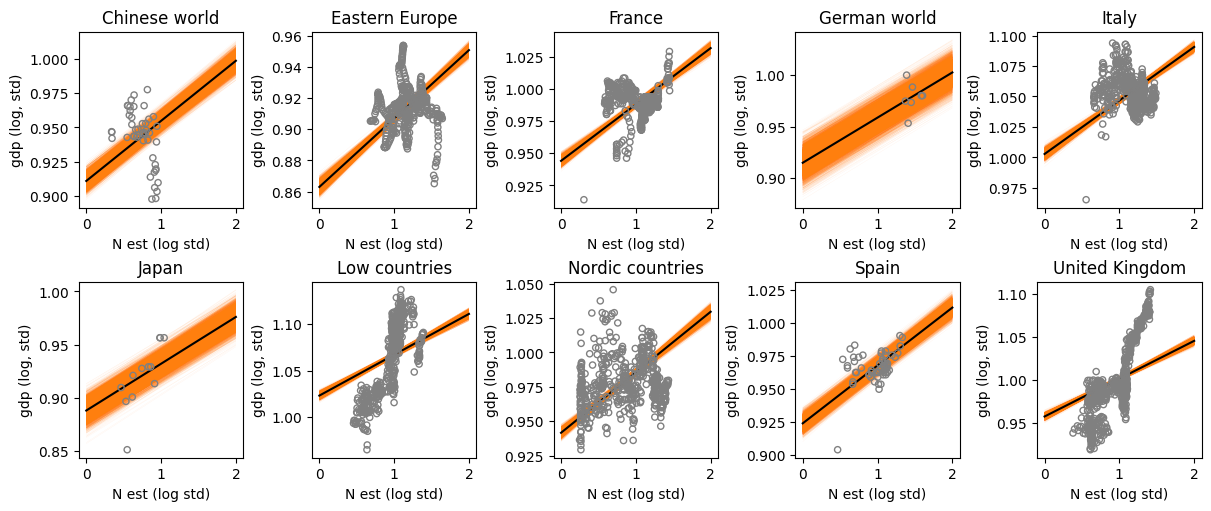

In [33]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est (log std)", title=region_name)

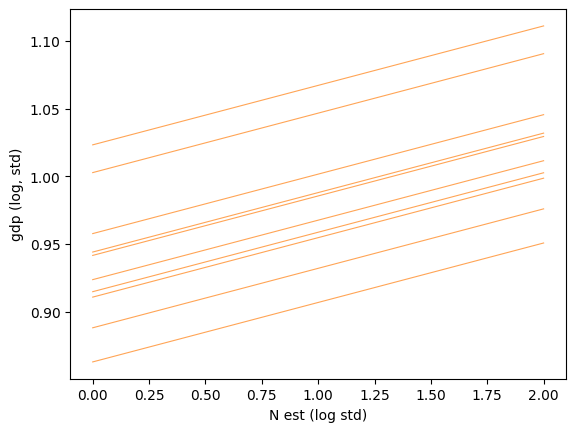

In [34]:
posterior = az.extract(m_est_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est (log std)");

#### Model comparison

We undertake a comparison of all models explored thus far, this time employing approximate leave-one-out cross-validation (LOO). The model incorporating varying intercepts on region and using cultural score as a global predictor appears to best fit the data. As expected, it is closely followed by the model utilizing bias-corrected cultural production scores. All models featuring varying intercepts significantly outperform those with a singular global intercept. The results are demonstrated in the subsequent table and accompanying figure.

In [35]:
waic_compare = az.compare(models, ic='LOO')

In [36]:
waic_compare

rank     elpd_loo      p_loo  \
log_gdp_std ~ score_log_std + (1|region_name)     0  7589.533077  11.332094   
log_gdp_std ~ N_est_log_std + (1|region_name)     1  7451.919095  11.270803   
log_gdp_std ~ (1|region_name)                     2  7146.633825  10.122564   
gdp ~ score_log_std                               3  4991.712237   2.724704   
gdp ~ N_est_log_std                               4  4862.263593   2.641139   

                                                 elpd_diff        weight  \
log_gdp_std ~ score_log_std + (1|region_name)     0.000000  9.822631e-01   
log_gdp_std ~ N_est_log_std + (1|region_name)   137.613982  5.399661e-08   
log_gdp_std ~ (1|region_name)                   442.899251  1.773688e-02   
gdp ~ score_log_std                            2597.820840  8.618862e-08   
gdp ~ N_est_log_std                            2727.269484  0.000000e+00   

                                                      se        dse  warning  \
log_gdp_std ~ score_log_std + (1|region_name)  41.136506   0.000000    False   
log_gdp_std ~ N_est_log_std + (1|region_name)  43.849622   8.425622    False   
log_gdp_std ~ (1|region_name)                  54.547425  30.097345    False   
gdp ~ score_log_std                            37.696639  50.153432    False   
gdp ~ N_est_log_std                            35.932671  48.121397    False   

                                              scale  
log_gdp_std ~ score_log_std + (1|region_name)   log  
log_gdp_std ~ N_est_log_std + (1|region_name)   log  
log_gdp_std ~ (1|region_name)                   log  
gdp ~ score_log_std                             log  
gdp ~ N_est_log_std                             log

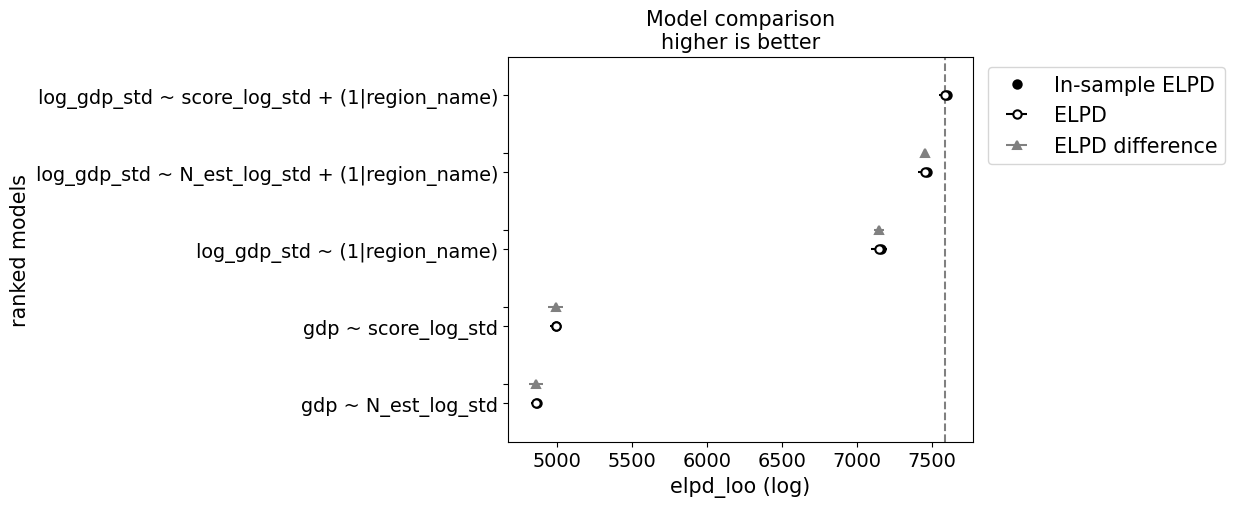

In [37]:
az.plot_compare(waic_compare, insample_dev=True);

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


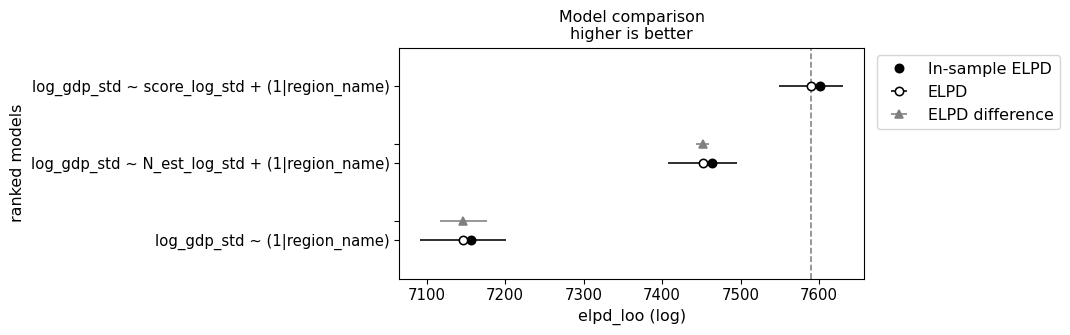

In [38]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("1|region_name")], insample_dev=True);

### Varying Slopes for Cultural Production in Different Regions

In our previous analysis, we presumed a global, uniform effect of cultural production on GDP per capita. However, upon observing significant discrepancies in the GDP intercepts per region, it's plausible that the relationship's slope between the cultural production score and GDP also varies. To cater to this, we construct a varying slope model with the following specification:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + (\beta + \beta_{\text{region}[i]}) x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\alpha}) \\
\beta_\text{region} & \sim \text{Normal}(0, \sigma_{\beta}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma_{\beta} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

As daunting as this might seem, it can be implemented relatively straightforward, as shown below. Also note that we could further improve the model by modeling the dependence of the priors on the varying slopes and intercepts. For now we treat them as independent priors, which may not be the most efficient way to do it.

In [39]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_vs

       Formula: log_gdp_std ~ score_log_std + (score_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

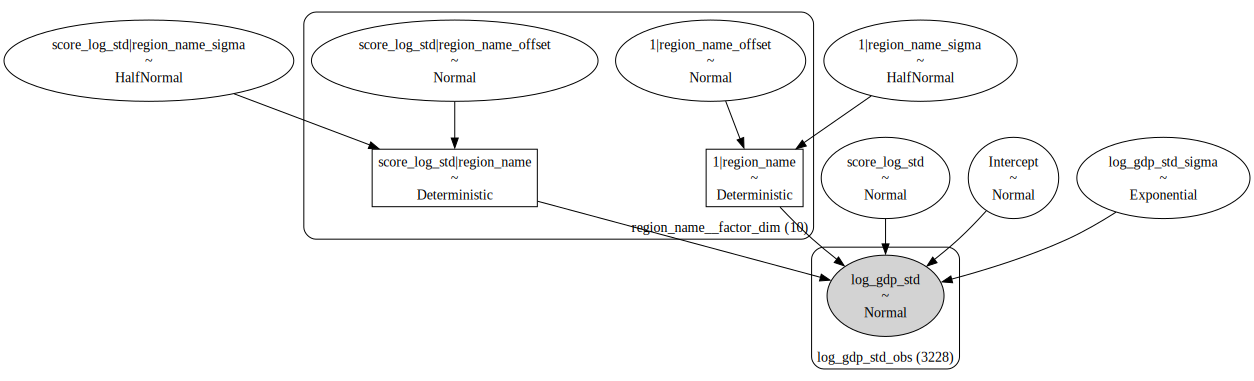

In [40]:
m_score_vs.build()
m_score_vs.graph()

Despite a considerable surge in the model's complexity, efficient sampling persists, marked by commendable $\hat{r}$ values and satisfactory effective sample sizes. The model's summary is provided below. A key observation we promptly make is the elimination of the unmistakably positive main, global effect of the cultural production score. Instead, it intersects 0 within the 97% confidence intervals, suggesting the effect is not solely positive. We'll elaborate on this further in the ensuing section.

In [41]:
m_score_vs_fit = m_score_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (score_log_std|region_name)"] = m_score_vs_fit
az.summary(m_score_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 372 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.960  0.020   0.923    0.999   
score_log_std                                0.022  0.018  -0.014    0.055   
log_gdp_std_sigma                            0.017  0.000   0.017    0.017   
1|region_name_sigma                          0.060  0.017   0.033    0.091   
score_log_std|region_name_sigma              0.055  0.017   0.031    0.087   
1|region_name[Chinese world]                 0.020  0.022  -0.021    0.061   
1|region_name[Eastern Europe]               -0.043  0.020  -0.080   -0.004   
1|region_name[France]                        0.026  0.020  -0.011    0.065   
1|region_name[German world]                 -0.001  0.039  -0.075    0.069   
1|region_name[Italy]                         0.104  0.020   0.063    0.141   
1|region_name[Japan]                        -0.084  0.023  -0.127   -0.042   
1|region_name[Low countries]                 0.006  0.020  -0.032    0.044   
1|region_name[Nordic countries]              0.014  0.020  -0.024    0.052   
1|region_name[Spain]                        -0.008  0.021  -0.048    0.032   
1|region_name[United Kingdom]               -0.037  0.020  -0.075    0.001   
score_log_std|region_name[Chinese world]    -0.075  0.022  -0.116   -0.034   
score_log_std|region_name[Eastern Europe]   -0.025  0.018  -0.057    0.011   
score_log_std|region_name[France]           -0.019  0.018  -0.052    0.017   
score_log_std|region_name[German world]     -0.010  0.027  -0.062    0.041   
score_log_std|region_name[Italy]            -0.031  0.018  -0.064    0.005   
score_log_std|region_name[Japan]             0.048  0.023   0.002    0.090   
score_log_std|region_name[Low countries]     0.072  0.018   0.038    0.106   
score_log_std|region_name[Nordic countries] -0.017  0.018  -0.049    0.019   
score_log_std|region_name[Spain]            -0.007  0.019  -0.044    0.028   
score_log_std|region_name[United Kingdom]    0.060  0.018   0.028    0.096   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.000      0.0    2435.0   
score_log_std                                    0.000      0.0    2457.0   
log_gdp_std_sigma                                0.000      0.0    8828.0   
1|region_name_sigma                              0.000      0.0    2536.0   
score_log_std|region_name_sigma                  0.000      0.0    2631.0   
1|region_name[Chinese world]                     0.000      0.0    2850.0   
1|region_name[Eastern Europe]                    0.000      0.0    2508.0   
1|region_name[France]                            0.000      0.0    2434.0   
1|region_name[German world]                      0.001      0.0    5921.0   
1|region_name[Italy]                             0.000      0.0    2492.0   
1|region_name[Japan]                             0.000      0.0    2887.0   
1|region_name[Low countries]                     0.000      0.0    2472.0   
1|region_name[Nordic countries]                  0.000      0.0    2429.0   
1|region_name[Spain]                             0.000      0.0    2690.0   
1|region_name[United Kingdom]                    0.000      0.0    2422.0   
score_log_std|region_name[Chinese world]         0.000      0.0    3489.0   
score_log_std|region_name[Eastern Europe]        0.000      0.0    2501.0   
score_log_std|region_name[France]                0.000      0.0    2499.0   
score_log_std|region_name[German world]          0.000      0.0    3952.0   
score_log_std|region_name[Italy]                 0.000      0.0    2500.0   
score_log_std|region_name[Japan]                 0.000      0.0    3661.0   
score_log_std|region_name[Low countries]         0.000      0.0    2486.0   
score_log_std|region_name[Nordic countries]      0.000      0.0    2454.0   
score_log_std|region_name[Spain]                 0.000      0.0    2735.0   
score_log_std|region_name[United Kingdom]        0.000      0.0    2469.0   

              

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

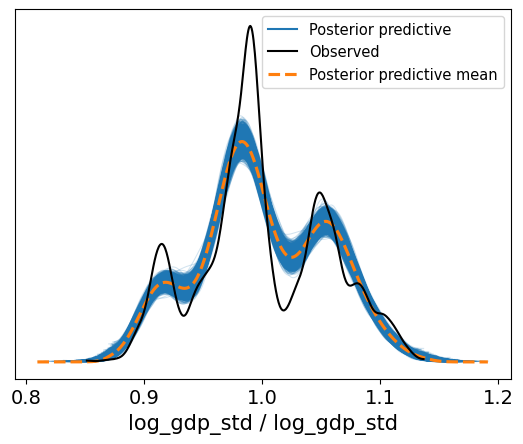

In [42]:
m_score_vs.predict(m_score_vs_fit, kind="pps")
az.plot_ppc(m_score_vs_fit);

The superior model fit becomes palpably apparent when we map the posterior predictions against the observations per region. In most instances, the varying slopes seem to align seamlessly with the data. A vital insight garnered from this plot is that the relationship between GDP and cultural production isn't universally positive across all regions. A pronounced positive correlation between the two variables is noticeable for the Low Countries, the United Kingdom, Japan, and to a slightly lesser degree, Spain. Conversely, the relationship appears inverted for the Chinese World, Eastern Europe, Italy, and the Arabic World. Portugal, France, and Central Europe do not appear to exhibit a distinct relationship, neither positive nor negative.

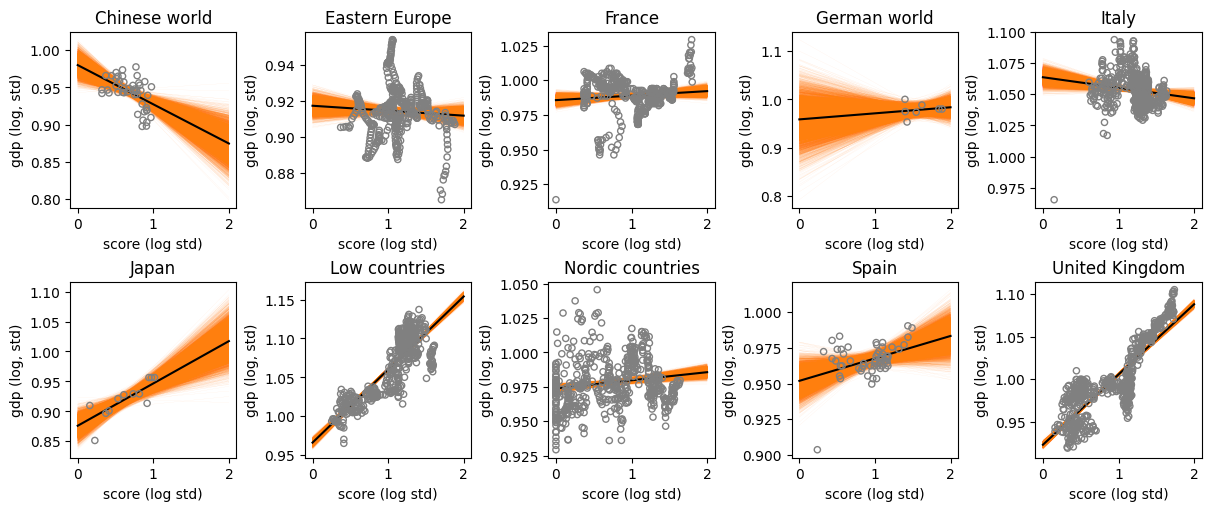

In [43]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

The ensuing plot illustrates the mean posterior distribution for each region, facilitating a more discernible understanding of regions that showcase a positive correlation between GDP and cultural production, and those that bear a negative or ambiguous relationship. The plot vividly indicates that some regions maintain a positive association, while others harbor a negative one. Thus, this analysis affirms that the incorporation of varying slopes in our model was justified and introduces valuable nuance to our exploration. **It underlines that we cannot unequivocally assert a positive correlation between cultural production and GDP, as this relationship varies by region.**

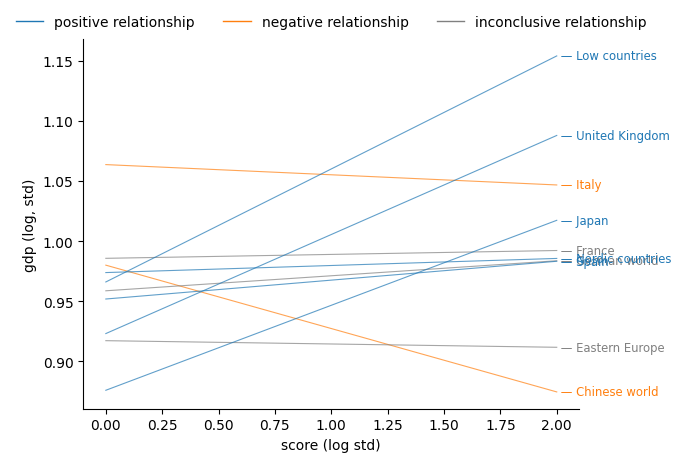

In [44]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score (log std)");

#### Covarying slopes and intercepts

To further scrutinize the region-specific slope attributes, we illustrate the covariance between region-specific intercepts and slopes. The hypothesis is the potential correlation between the intercepts and slopes, which may indicate, for instance, an enhanced or diminished GDP increase or decrease corresponding to higher or lower intercepts. The ensuing plot depicts this relationship. Although most regions don't seem to manifest a distinctly pronounced relationship between intercepts and slopes, there are a handful of intriguing cases where interaction is noticeable. For instance, in the German world, the Greek world, and in the Latin world, a negative correlation is observed, implying a decrease in slope as the intercept escalates. Contrarily, regions like the Low Countries, although having an average intercept (hence its position around zero), boast an above-average slope. On the other hand, the Chinese world, despite having an average intercept, showcases a below-average slope.

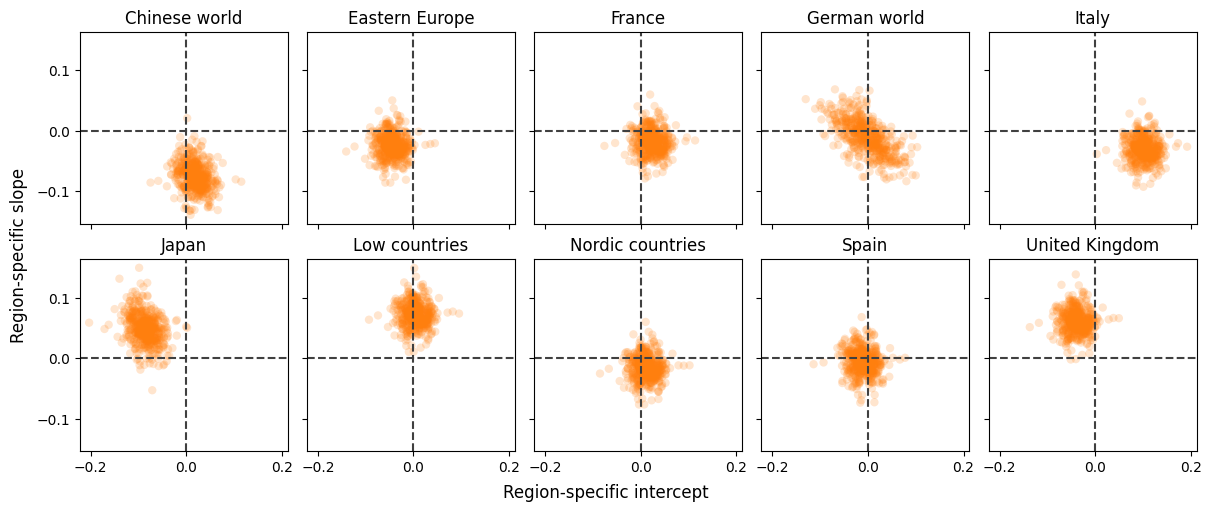

In [45]:
import matplotlib

regions = df["region_name"].unique()

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

# #  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(m_score_vs_fit, num_samples=500)
for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    post = posterior.sel(region_name__factor_dim=region)
    X = post["1|region_name"].data
    Y = post["score_log_std|region_name"].data
    ax.scatter(
        X, Y,
        facecolor="C1", edgecolor="none", alpha=0.2)
    ax.set(title=region)

    ax.axhline(c="0.25", ls="--")
    ax.axvline(c="0.25", ls="--")
    
fig.supylabel('Region-specific slope')
fig.supxlabel('Region-specific intercept');
plt.savefig("covariance-plot.pdf")

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [46]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_vs

       Formula: log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [47]:
m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit
az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 527 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.946  0.027   0.897    0.996   
N_est_log_std                                0.037  0.028  -0.015    0.090   
log_gdp_std_sigma                            0.018  0.000   0.017    0.018   
1|region_name_sigma                          0.078  0.023   0.042    0.121   
N_est_log_std|region_name_sigma              0.083  0.025   0.045    0.128   
1|region_name[Chinese world]                 0.042  0.029  -0.011    0.096   
1|region_name[Eastern Europe]               -0.028  0.027  -0.078    0.023   
1|region_name[France]                        0.038  0.027  -0.012    0.088   
1|region_name[German world]                 -0.001  0.058  -0.109    0.109   
1|region_name[Italy]                         0.124  0.027   0.076    0.177   
1|region_name[Japan]                        -0.100  0.032  -0.159   -0.042   
1|region_name[Low countries]                -0.023  0.027  -0.075    0.026   
1|region_name[Nordic countries]              0.025  0.027  -0.026    0.074   
1|region_name[Spain]                        -0.001  0.028  -0.052    0.056   
1|region_name[United Kingdom]               -0.079  0.027  -0.130   -0.030   
N_est_log_std|region_name[Chinese world]    -0.098  0.031  -0.157   -0.040   
N_est_log_std|region_name[Eastern Europe]   -0.040  0.028  -0.090    0.016   
N_est_log_std|region_name[France]           -0.032  0.028  -0.086    0.020   
N_est_log_std|region_name[German world]     -0.014  0.045  -0.100    0.067   
N_est_log_std|region_name[Italy]            -0.051  0.028  -0.103    0.003   
N_est_log_std|region_name[Japan]             0.062  0.036  -0.001    0.132   
N_est_log_std|region_name[Low countries]     0.113  0.028   0.059    0.165   
N_est_log_std|region_name[Nordic countries] -0.028  0.028  -0.080    0.025   
N_est_log_std|region_name[Spain]            -0.015  0.030  -0.072    0.039   
N_est_log_std|region_name[United Kingdom]    0.103  0.028   0.051    0.156   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.001    0.000    2526.0   
N_est_log_std                                    0.001    0.000    2477.0   
log_gdp_std_sigma                                0.000    0.000    9843.0   
1|region_name_sigma                              0.000    0.000    3149.0   
N_est_log_std|region_name_sigma                  0.000    0.000    3339.0   
1|region_name[Chinese world]                     0.001    0.000    2845.0   
1|region_name[Eastern Europe]                    0.001    0.000    2566.0   
1|region_name[France]                            0.001    0.000    2580.0   
1|region_name[German world]                      0.001    0.001    6442.0   
1|region_name[Italy]                             0.001    0.000    2577.0   
1|region_name[Japan]                             0.001    0.000    3435.0   
1|region_name[Low countries]                     0.001    0.000    2561.0   
1|region_name[Nordic countries]                  0.001    0.000    2539.0   
1|region_name[Spain]                             0.001    0.000    2765.0   
1|region_name[United Kingdom]                    0.001    0.000    2538.0   
N_est_log_std|region_name[Chinese world]         0.001    0.000    3091.0   
N_est_log_std|region_name[Eastern Europe]        0.001    0.000    2505.0   
N_est_log_std|region_name[France]                0.001    0.000    2513.0   
N_est_log_std|region_name[German world]          0.001    0.001    3750.0   
N_est_log_std|region_name[Italy]                 0.001    0.000    2486.0   
N_est_log_std|region_name[Japan]                 0.001    0.000    3572.0   
N_est_log_std|region_name[Low countries]         0.001    0.000    2500.0   
N_est_log_std|region_name[Nordic countries]      0.001    0.000    2492.0   
N_est_log_std|region_name[Spain]                 0.001    0.000    2698.0   
N_est_log_std|region_name[United Kingdom]        0.001    0.000    2500.0   

              

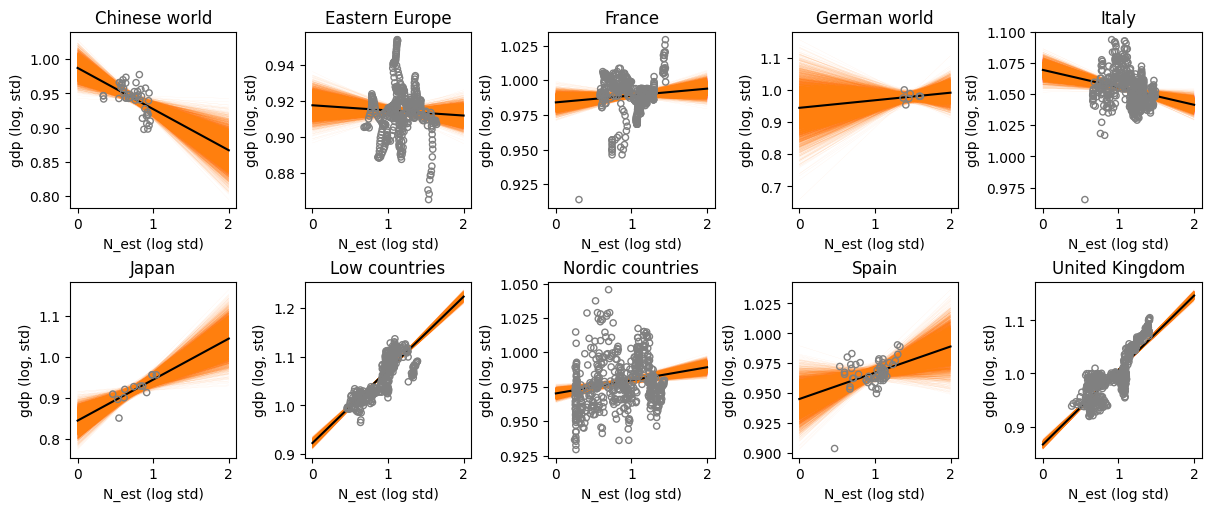

In [48]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est (log std)", title=region_name)

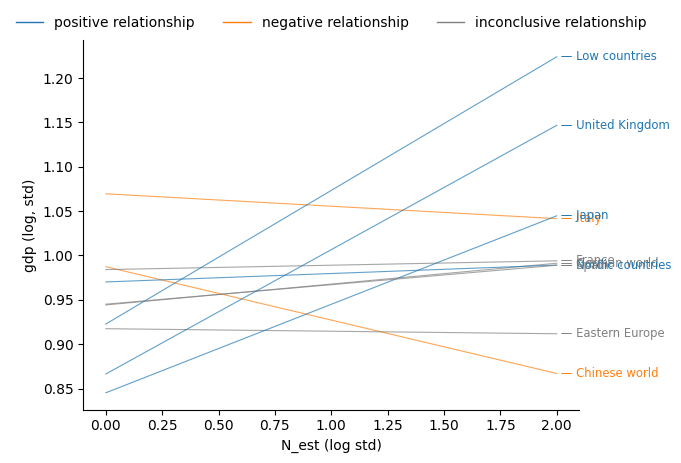

In [49]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models.

In [50]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

rank     elpd_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0  8554.571104   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1  8413.017020   
log_gdp_std ~ score_log_std + (1|region_name)          2  7589.533077   
log_gdp_std ~ N_est_log_std + (1|region_name)          3  7451.919095   
log_gdp_std ~ (1|region_name)                          4  7146.633825   
gdp ~ score_log_std                                    5  4991.712237   
gdp ~ N_est_log_std                                    6  4862.263593   

                                                        p_loo    elpd_diff  \
log_gdp_std ~ score_log_std + (score_log_std|re...  22.398881     0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  21.638889   141.554084   
log_gdp_std ~ score_log_std + (1|region_name)       11.332094   965.038027   
log_gdp_std ~ N_est_log_std + (1|region_name)       11.270803  1102.652009   
log_gdp_std ~ (1|region_name)                       10.122564  1407.937278   
gdp ~ score_log_std                                  2.724704  3562.858867   
gdp ~ N_est_log_std                                  2.641139  3692.307511   

                                                          weight         se  \
log_gdp_std ~ score_log_std + (score_log_std|re...  9.532523e-01  49.070418   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  9.644089e-10  49.470601   
log_gdp_std ~ score_log_std + (1|region_name)       2.549547e-02  41.136506   
log_gdp_std ~ N_est_log_std + (1|region_name)       4.227703e-09  43.849622   
log_gdp_std ~ (1|region_name)                       2.125219e-02  54.547425   
gdp ~ score_log_std                                 7.933684e-09  37.696639   
gdp ~ N_est_log_std                                 0.000000e+00  35.932671   

                                                          dse  warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000    False   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  12.084326    False   log  
log_gdp_std ~ score_log_std + (1|region_name)       46.274537    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)       49.604154    False   log  
log_gdp_std ~ (1|region_name)                       60.481222    False   log  
gdp ~ score_log_std                                 59.850486    False   log  
gdp ~ N_est_log_std                                 58.248023    False   log

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


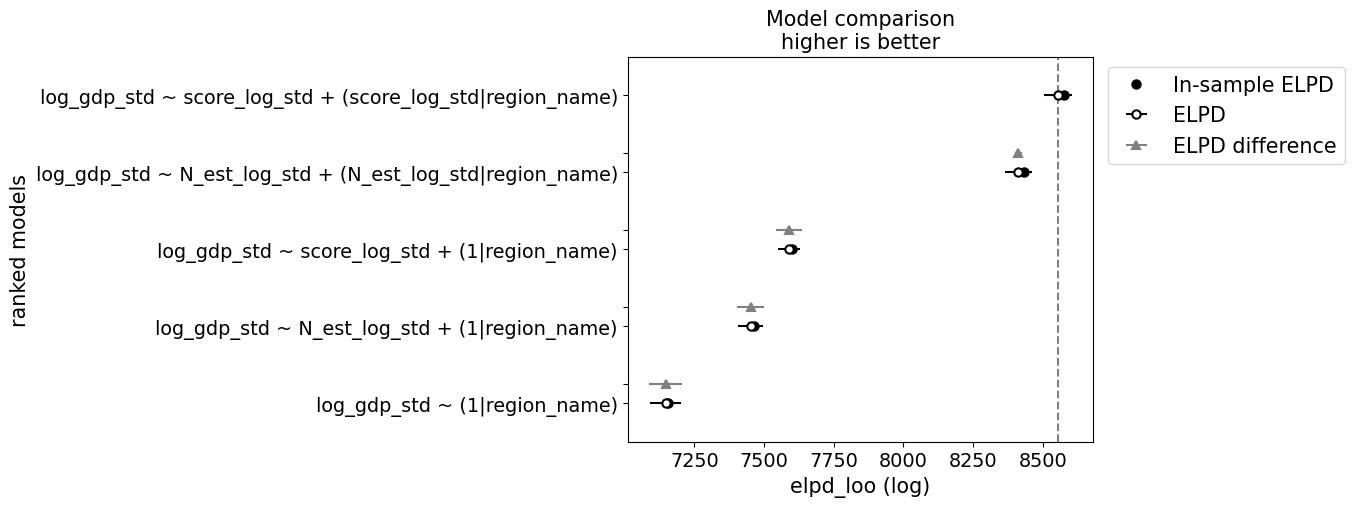

In [51]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

# Cultural score per capita

In the analsyses above, we correlated a global cultural production score (both corrected and uncorrected) with the GDP scores per capita. These scores ignore differences in population size. As a final step in the analysis, we repeat the analyses with varying intercepts and varying slopes, but swapping the unnormalized cultural production scores for the scores per capita. We begin with the uncorrected score:

In [52]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vi = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_cap_vi

       Formula: log_gdp_std ~ score_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

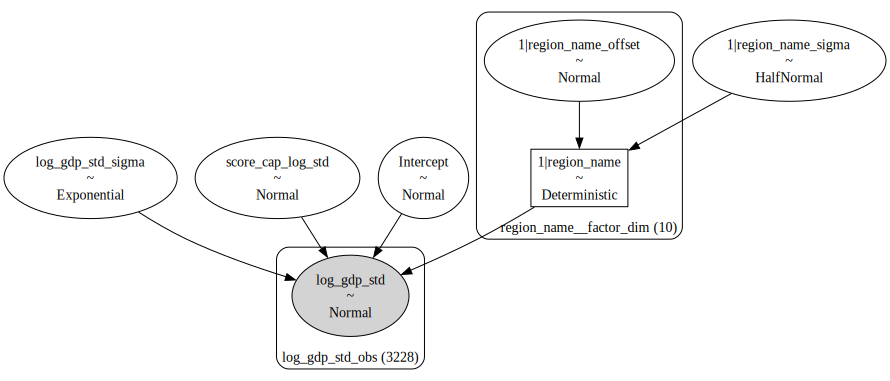

In [53]:
m_score_cap_vi.build()
m_score_cap_vi.graph()

In [54]:
m_score_cap_vi_fit = m_score_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_cap_log_std + (1|region_name)"] = m_score_cap_vi_fit
az.summary(m_score_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 95 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.963  0.017   0.932    0.995        0.0   
score_cap_log_std                0.023  0.001   0.022    0.025        0.0   
log_gdp_std_sigma                0.023  0.000   0.023    0.024        0.0   
1|region_name_sigma              0.050  0.014   0.028    0.076        0.0   
1|region_name[Chinese world]    -0.000  0.017  -0.032    0.032        0.0   
1|region_name[Eastern Europe]   -0.069  0.017  -0.100   -0.037        0.0   
1|region_name[France]            0.010  0.017  -0.021    0.042        0.0   
1|region_name[German world]     -0.022  0.018  -0.058    0.013        0.0   
1|region_name[Italy]             0.063  0.017   0.031    0.094        0.0   
1|region_name[Japan]            -0.042  0.018  -0.076   -0.009        0.0   
1|region_name[Low countries]     0.068  0.017   0.037    0.100        0.0   
1|region_name[Nordic countries] -0.009  0.017  -0.041    0.022        0.0   
1|region_name[Spain]            -0.016  0.017  -0.048    0.015        0.0   
1|region_name[United Kingdom]    0.013  0.017  -0.017    0.046        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1486.0    2365.0    1.0  
score_cap_log_std                    0.0    5883.0    4805.0    1.0  
log_gdp_std_sigma                    0.0    4452.0    4167.0    1.0  
1|region_name_sigma                  0.0    1621.0    2961.0    1.0  
1|region_name[Chinese world]         0.0    1528.0    2476.0    1.0  
1|region_name[Eastern Europe]        0.0    1495.0    2398.0    1.0  
1|region_name[France]                0.0    1483.0    2425.0    1.0  
1|region_name[German world]          0.0    1750.0    2926.0    1.0  
1|region_name[Italy]                 0.0    1491.0    2379.0    1.0  
1|region_name[Japan]                 0.0    1646.0    2639.0    1.0  
1|region_name[Low countries]         0.0    1493.0    2365.0    1.0  
1|region_name[Nordic countries]      0.0    1484.0    2382.0    1.0  
1|region_name[Spain]                 0.0    1492.0    2542.0    1.0  
1|region_name[United Kingdom]        0.0    1482.0    2411.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.023 CI [0.022, 0.025]). It seems that the model fit is decent. 

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


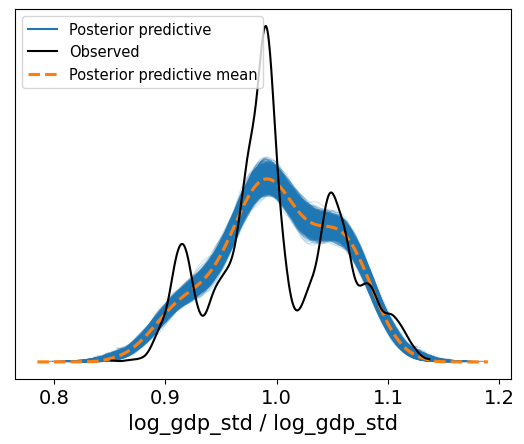

In [55]:
m_score_cap_vi.predict(m_score_cap_vi_fit, kind="pps")
az.plot_ppc(m_score_cap_vi_fit);

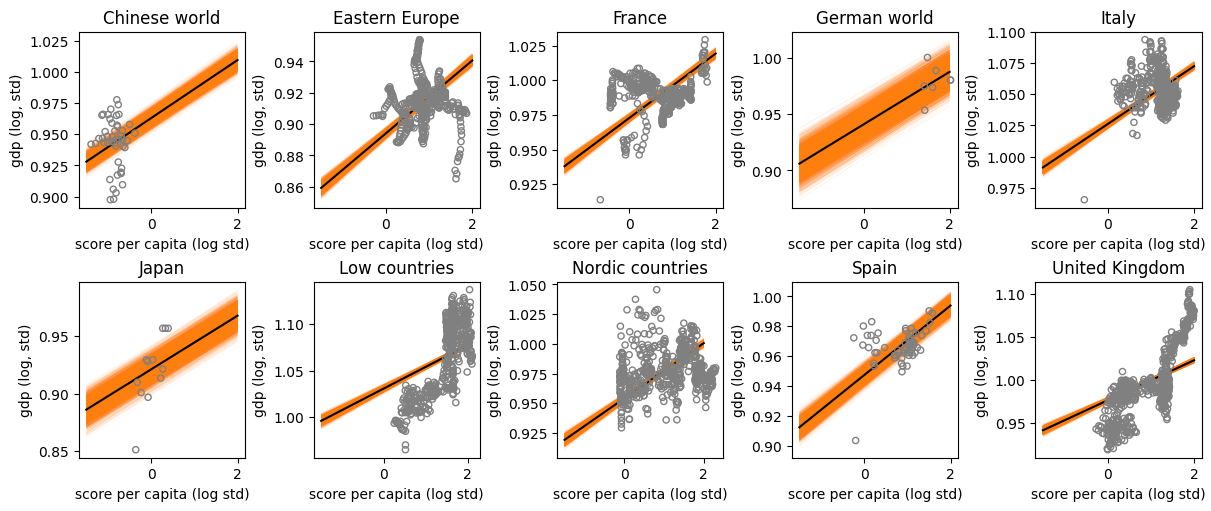

In [56]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

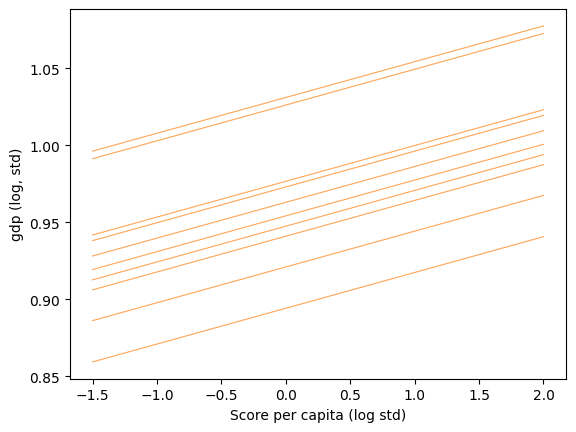

In [57]:
posterior = az.extract(m_score_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score per capita (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [58]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vi = bmb.Model(
    "log_gdp_std ~ N_est_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_cap_vi

       Formula: log_gdp_std ~ N_est_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [59]:
m_est_cap_vi_fit = m_est_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (1|region_name)"] = m_est_cap_vi_fit
az.summary(m_est_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 87 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.949  0.018   0.917    0.985        0.0   
N_est_cap_log_std                0.036  0.002   0.033    0.038        0.0   
log_gdp_std_sigma                0.024  0.000   0.024    0.025        0.0   
1|region_name_sigma              0.054  0.015   0.030    0.081        0.0   
1|region_name[Chinese world]    -0.005  0.018  -0.041    0.027        0.0   
1|region_name[Eastern Europe]   -0.072  0.018  -0.106   -0.039        0.0   
1|region_name[France]            0.010  0.018  -0.024    0.043        0.0   
1|region_name[German world]     -0.022  0.020  -0.058    0.016        0.0   
1|region_name[Italy]             0.065  0.018   0.031    0.098        0.0   
1|region_name[Japan]            -0.045  0.019  -0.080   -0.009        0.0   
1|region_name[Low countries]     0.077  0.018   0.042    0.109        0.0   
1|region_name[Nordic countries] -0.008  0.018  -0.043    0.024        0.0   
1|region_name[Spain]            -0.016  0.018  -0.051    0.017        0.0   
1|region_name[United Kingdom]    0.015  0.018  -0.020    0.048        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1399.0    1764.0    1.0  
N_est_cap_log_std                    0.0    5442.0    4585.0    1.0  
log_gdp_std_sigma                    0.0    6279.0    4916.0    1.0  
1|region_name_sigma                  0.0    1391.0    2109.0    1.0  
1|region_name[Chinese world]         0.0    1442.0    1942.0    1.0  
1|region_name[Eastern Europe]        0.0    1404.0    1817.0    1.0  
1|region_name[France]                0.0    1403.0    1739.0    1.0  
1|region_name[German world]          0.0    1634.0    2157.0    1.0  
1|region_name[Italy]                 0.0    1403.0    1734.0    1.0  
1|region_name[Japan]                 0.0    1574.0    2015.0    1.0  
1|region_name[Low countries]         0.0    1403.0    1802.0    1.0  
1|region_name[Nordic countries]      0.0    1401.0    1764.0    1.0  
1|region_name[Spain]                 0.0    1435.0    1864.0    1.0  
1|region_name[United Kingdom]        0.0    1399.0    1819.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

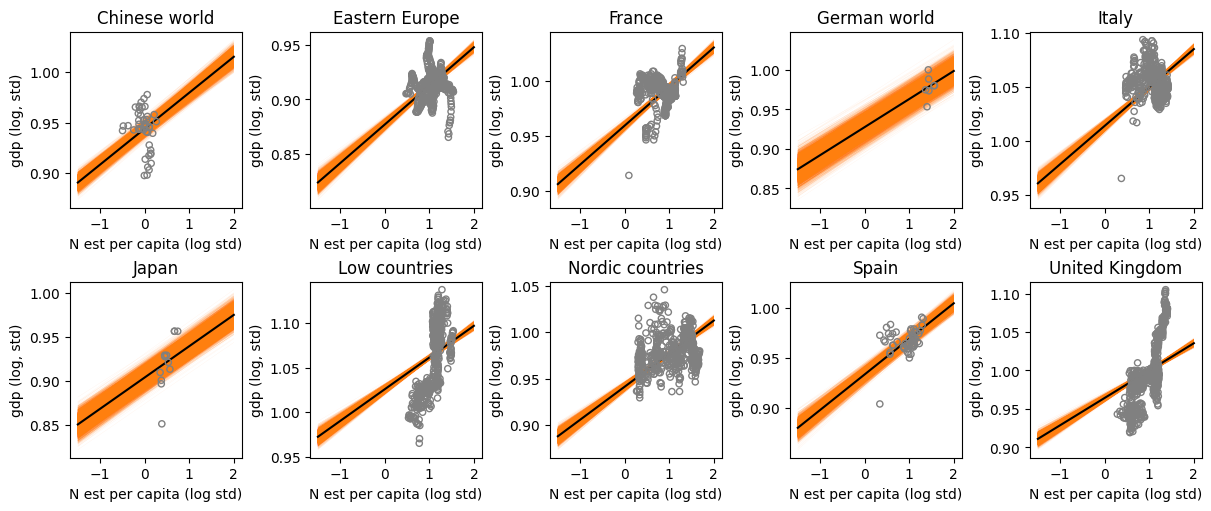

In [60]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est per capita (log std)", title=region_name)

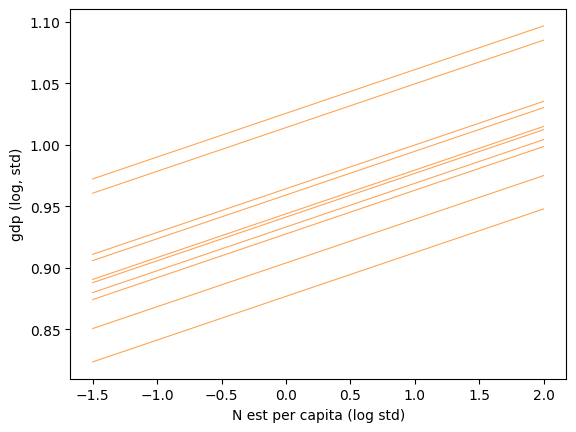

In [61]:
posterior = az.extract(m_est_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est per capita (log std)");

### Varying Slopes for Cultural Production in Different Regions

In [62]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vs = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_cap_vs

       Formula: log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

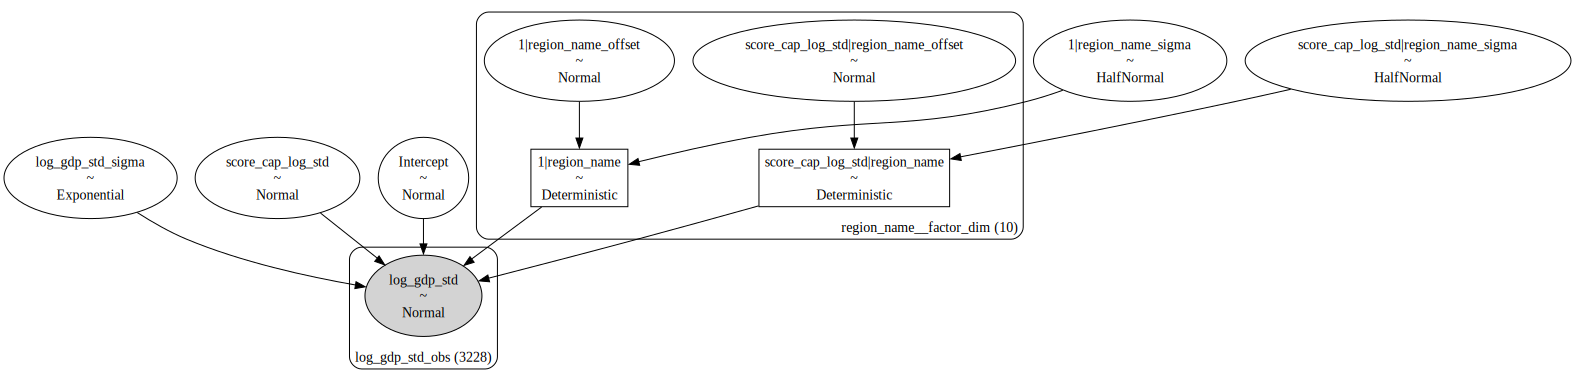

In [63]:
m_score_cap_vs.build()
m_score_cap_vs.graph()

In [64]:
m_score_cap_vs_fit = m_score_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)"] = m_score_cap_vs_fit
az.summary(m_score_cap_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset, score_cap_log_std|region_name_sigma, score_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 214 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        0.962  0.016   0.931   
score_cap_log_std                                0.021  0.012  -0.002   
log_gdp_std_sigma                                0.018  0.000   0.017   
1|region_name_sigma                              0.048  0.014   0.026   
score_cap_log_std|region_name_sigma              0.037  0.011   0.020   
1|region_name[Chinese world]                    -0.022  0.019  -0.056   
1|region_name[Eastern Europe]                   -0.046  0.016  -0.076   
1|region_name[France]                            0.026  0.016  -0.005   
1|region_name[German world]                     -0.006  0.031  -0.067   
1|region_name[Italy]                             0.094  0.016   0.064   
1|region_name[Japan]                            -0.043  0.017  -0.072   
1|region_name[Low countries]                     0.007  0.016  -0.023   
1|region_name[Nordic countries]                  0.012  0.016  -0.018   
1|region_name[Spain]                            -0.003  0.017  -0.034   
1|region_name[United Kingdom]                   -0.017  0.016  -0.049   
score_cap_log_std|region_name[Chinese world]    -0.025  0.016  -0.055   
score_cap_log_std|region_name[Eastern Europe]   -0.023  0.013  -0.046   
score_cap_log_std|region_name[France]           -0.019  0.012  -0.041   
score_cap_log_std|region_name[German world]     -0.008  0.020  -0.046   
score_cap_log_std|region_name[Italy]            -0.023  0.013  -0.047   
score_cap_log_std|region_name[Japan]             0.049  0.021   0.009   
score_cap_log_std|region_name[Low countries]     0.045  0.012   0.022   
score_cap_log_std|region_name[Nordic countries] -0.017  0.012  -0.041   
score_cap_log_std|region_name[Spain]            -0.013  0.013  -0.038   
score_cap_log_std|region_name[United Kingdom]    0.035  0.012   0.010   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          0.992        0.0      0.0   
score_cap_log_std                                  0.045        0.0      0.0   
log_gdp_std_sigma                                  0.018        0.0      0.0   
1|region_name_sigma                                0.074        0.0      0.0   
score_cap_log_std|region_name_sigma                0.059        0.0      0.0   
1|region_name[Chinese world]                       0.014        0.0      0.0   
1|region_name[Eastern Europe]                     -0.016        0.0      0.0   
1|region_name[France]                              0.056        0.0      0.0   
1|region_name[German world]                        0.050        0.0      0.0   
1|region_name[Italy]                               0.125        0.0      0.0   
1|region_name[Japan]                              -0.009        0.0      0.0   
1|region_name[Low countries]                       0.038        0.0      0.0   
1|region_name[Nordic countries]                    0.042        0.0      0.0   
1|region_name[Spain]                               0.029        0.0      0.0   
1|region_name[United Kingdom]                      0.012        0.0      0.0   
score_cap_log_std|region_name[Chinese world]       0.008        0.0      0.0   
score_cap_log_std|region_name[Eastern Europe]      0.002        0.0      0.0   
score_cap_log_std|region_name[France]              0.006        0.0      0.0   
score_cap_log_std|region_name[German world]        0.029        0.0      0.0   
score_cap_log_std|region_name[Italy]               0.001        0.0      0.0   
score_cap_log_std|region_name[Japan]               0.089        0.0      0.0   
score_cap_log_std|region_name[Low countries]       0.070        0.0      0.0   
score_cap_log_std|region_name[Nordic countries]    0.006        0.0      0.0   
score_cap_log_std|region_name[Spain]               0.013        0.0      0.0   
score_cap_log_std|region_name[United Kingdom]      0.058        0.0      0.0   

                                                 ess_bulk  ess_tail  r

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

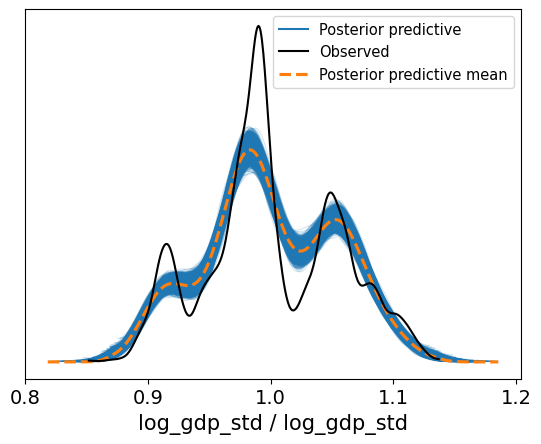

In [65]:
m_score_cap_vs.predict(m_score_cap_vs_fit, kind="pps")
az.plot_ppc(m_score_cap_vs_fit);

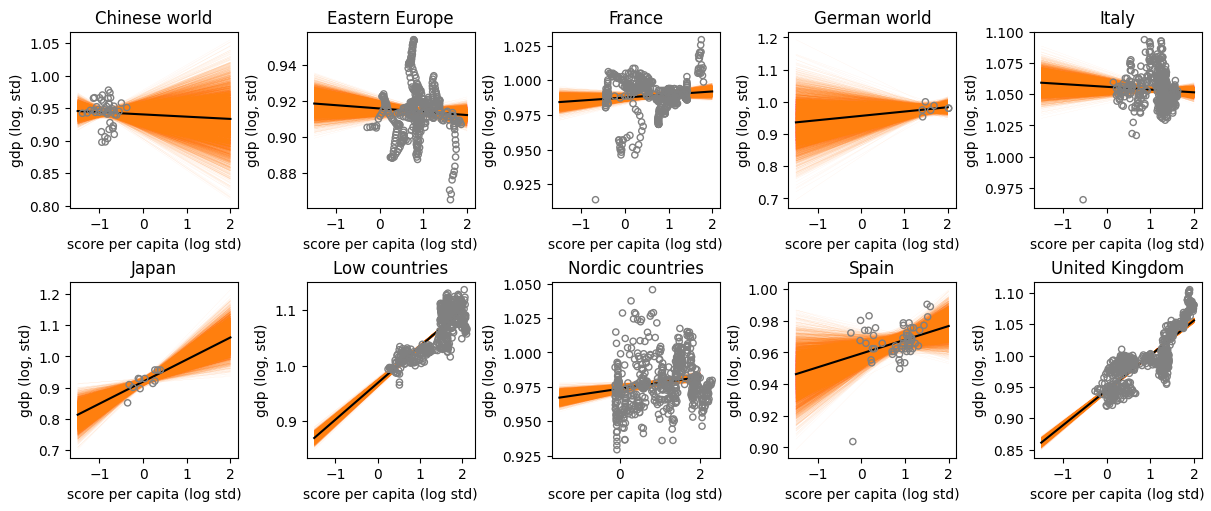

In [66]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

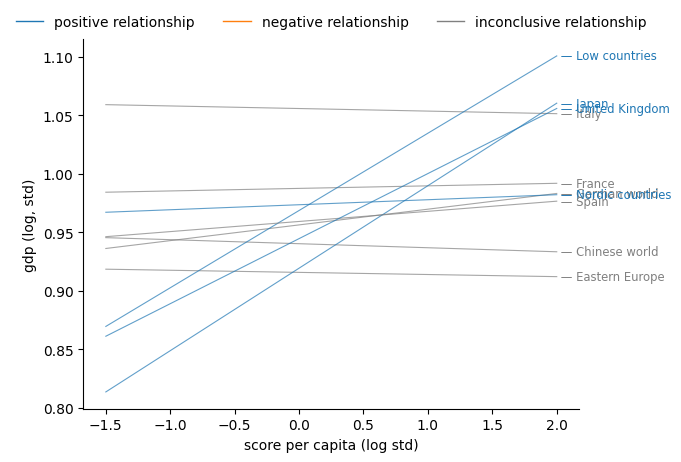

In [67]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score per capita (log std)");

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [68]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vs = bmb.Model(
    "log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_cap_vs

       Formula: log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [69]:
m_est_cap_vs_fit = m_est_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (N_est_cap_log_std|region_name)"] = m_est_cap_vs_fit
az.summary(m_est_cap_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_cap_log_std|region_name_sigma, N_est_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 395 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        0.942  0.024   0.894   
N_est_cap_log_std                                0.040  0.026  -0.007   
log_gdp_std_sigma                                0.019  0.000   0.018   
1|region_name_sigma                              0.072  0.021   0.038   
N_est_cap_log_std|region_name_sigma              0.078  0.024   0.041   
1|region_name[Chinese world]                     0.001  0.024  -0.046   
1|region_name[Eastern Europe]                   -0.025  0.024  -0.070   
1|region_name[France]                            0.044  0.024   0.000   
1|region_name[German world]                     -0.009  0.056  -0.115   
1|region_name[Italy]                             0.122  0.024   0.072   
1|region_name[Japan]                            -0.085  0.030  -0.144   
1|region_name[Low countries]                    -0.029  0.024  -0.074   
1|region_name[Nordic countries]                  0.028  0.024  -0.017   
1|region_name[Spain]                             0.010  0.026  -0.038   
1|region_name[United Kingdom]                   -0.062  0.024  -0.107   
N_est_cap_log_std|region_name[Chinese world]    -0.073  0.030  -0.129   
N_est_cap_log_std|region_name[Eastern Europe]   -0.042  0.026  -0.091   
N_est_cap_log_std|region_name[France]           -0.036  0.026  -0.087   
N_est_cap_log_std|region_name[German world]     -0.009  0.043  -0.089   
N_est_cap_log_std|region_name[Italy]            -0.050  0.026  -0.102   
N_est_cap_log_std|region_name[Japan]             0.087  0.043   0.008   
N_est_cap_log_std|region_name[Low countries]     0.098  0.026   0.048   
N_est_cap_log_std|region_name[Nordic countries] -0.032  0.026  -0.080   
N_est_cap_log_std|region_name[Spain]            -0.025  0.027  -0.076   
N_est_cap_log_std|region_name[United Kingdom]    0.081  0.026   0.032   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          0.986      0.001    0.000   
N_est_cap_log_std                                  0.090      0.001    0.000   
log_gdp_std_sigma                                  0.019      0.000    0.000   
1|region_name_sigma                                0.108      0.000    0.000   
N_est_cap_log_std|region_name_sigma                0.120      0.000    0.000   
1|region_name[Chinese world]                       0.047      0.001    0.000   
1|region_name[Eastern Europe]                      0.023      0.001    0.000   
1|region_name[France]                              0.093      0.001    0.000   
1|region_name[German world]                        0.097      0.001    0.001   
1|region_name[Italy]                               0.166      0.001    0.000   
1|region_name[Japan]                              -0.030      0.001    0.000   
1|region_name[Low countries]                       0.019      0.001    0.000   
1|region_name[Nordic countries]                    0.075      0.001    0.000   
1|region_name[Spain]                               0.059      0.001    0.000   
1|region_name[United Kingdom]                     -0.015      0.001    0.000   
N_est_cap_log_std|region_name[Chinese world]      -0.016      0.001    0.000   
N_est_cap_log_std|region_name[Eastern Europe]      0.006      0.001    0.000   
N_est_cap_log_std|region_name[France]              0.010      0.001    0.000   
N_est_cap_log_std|region_name[German world]        0.076      0.001    0.000   
N_est_cap_log_std|region_name[Italy]              -0.004      0.001    0.000   
N_est_cap_log_std|region_name[Japan]               0.170      0.001    0.000   
N_est_cap_log_std|region_name[Low countries]       0.145      0.001    0.000   
N_est_cap_log_std|region_name[Nordic countries]    0.017      0.001    0.000   
N_est_cap_log_std|region_name[Spain]               0.025      0.001    0.000   
N_est_cap_log_std|region_name[United Kingdom]      0.129      0.001    0.000   

                                                 ess_bulk  ess_tail  r

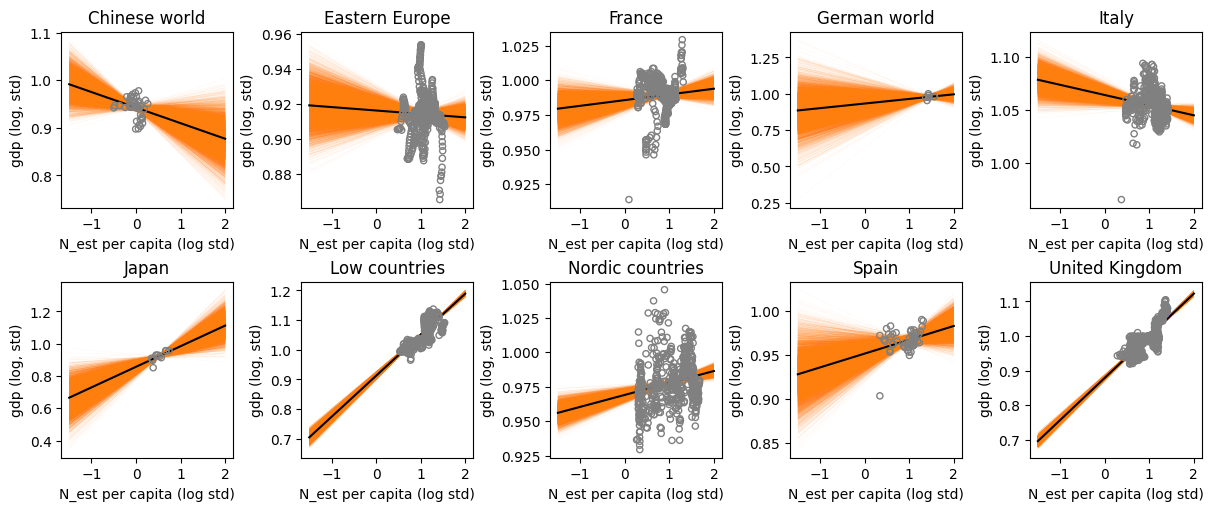

In [70]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)", title=region_name)

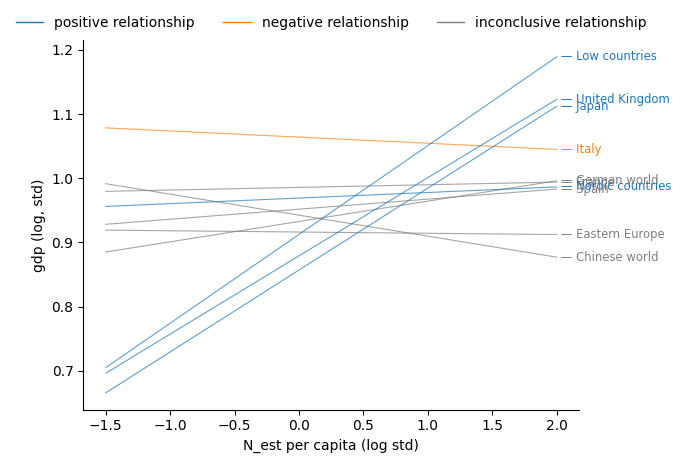

In [71]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models. Furthermore, we note that the bias-correction does not improve the model fit considerably. Finally, representing the cultural scores per capita does not improve the model fit either. 

In [72]:
waic_compare = az.compare(models, ic='LOO')

rank     elpd_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0  8554.571104   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1  8413.017020   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...     2  8397.649789   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...     3  8216.243901   
log_gdp_std ~ score_log_std + (1|region_name)          4  7589.533077   
log_gdp_std ~ score_cap_log_std + (1|region_name)      5  7555.937529   
log_gdp_std ~ N_est_log_std + (1|region_name)          6  7451.919095   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)      7  7398.751551   
log_gdp_std ~ (1|region_name)                          8  7146.633825   
gdp ~ score_log_std                                    9  4991.712237   
gdp ~ N_est_log_std                                   10  4862.263593   

                                                        p_loo    elpd_diff  \
log_gdp_std ~ score_log_std + (score_log_std|re...  22.398881     0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  21.638889   141.554084   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  21.105053   156.921315   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  19.698612   338.327203   
log_gdp_std ~ score_log_std + (1|region_name)       11.332094   965.038027   
log_gdp_std ~ score_cap_log_std + (1|region_name)   11.520268   998.633575   
log_gdp_std ~ N_est_log_std + (1|region_name)       11.270803  1102.652009   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   11.105267  1155.819553   
log_gdp_std ~ (1|region_name)                       10.122564  1407.937278   
gdp ~ score_log_std                                  2.724704  3562.858867   
gdp ~ N_est_log_std                                  2.641139  3692.307511   

                                                          weight         se  \
log_gdp_std ~ score_log_std + (score_log_std|re...  9.536458e-01  49.070418   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  0.000000e+00  49.470601   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  0.000000e+00  47.762016   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  1.796440e-08  47.687047   
log_gdp_std ~ score_log_std + (1|region_name)       1.457014e-02  41.136506   
log_gdp_std ~ score_cap_log_std + (1|region_name)   1.056944e-02  42.607555   
log_gdp_std ~ N_est_log_std + (1|region_name)       0.000000e+00  43.849622   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   0.000000e+00  45.880016   
log_gdp_std ~ (1|region_name)                       2.121465e-02  54.547425   
gdp ~ score_log_std                                 0.000000e+00  37.696639   
gdp ~ N_est_log_std                                 0.000000e+00  35.932671   

                                                          dse  warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000    False   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  12.084326    False   log  
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  14.345836    False   log  
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  18.169805    False   log  
log_gdp_std ~ score_log_std + (1|region_name)       46.274537    False   log  
log_gdp_std ~ score_cap_log_std + (1|region_name)   47.497950    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)       49.604154    False   log  
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   51.519180    False   log  
log_gdp_std ~ (1|region_name)                       60.481222    False   log  
gdp ~ score_log_std                                 59.850486    False   log  
gdp ~ N_est_log_std                                 58.248023    False   log

In [76]:
waic_compare['elpd_loo'] = round(waic_compare['elpd_loo'], 0)

In [77]:
waic_compare

rank  elpd_loo      p_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0    8555.0  22.398881   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1    8413.0  21.638889   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...     2    8398.0  21.105053   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...     3    8216.0  19.698612   
log_gdp_std ~ score_log_std + (1|region_name)          4    7590.0  11.332094   
log_gdp_std ~ score_cap_log_std + (1|region_name)      5    7556.0  11.520268   
log_gdp_std ~ N_est_log_std + (1|region_name)          6    7452.0  11.270803   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)      7    7399.0  11.105267   
log_gdp_std ~ (1|region_name)                          8    7147.0  10.122564   
gdp ~ score_log_std                                    9    4992.0   2.724704   
gdp ~ N_est_log_std                                   10    4862.0   2.641139   

                                                      elpd_diff        weight  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0.000000  9.536458e-01   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...   141.554084  0.000000e+00   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...   156.921315  0.000000e+00   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...   338.327203  1.796440e-08   
log_gdp_std ~ score_log_std + (1|region_name)        965.038027  1.457014e-02   
log_gdp_std ~ score_cap_log_std + (1|region_name)    998.633575  1.056944e-02   
log_gdp_std ~ N_est_log_std + (1|region_name)       1102.652009  0.000000e+00   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   1155.819553  0.000000e+00   
log_gdp_std ~ (1|region_name)                       1407.937278  2.121465e-02   
gdp ~ score_log_std                                 3562.858867  0.000000e+00   
gdp ~ N_est_log_std                                 3692.307511  0.000000e+00   

                                                           se        dse  \
log_gdp_std ~ score_log_std + (score_log_std|re...  49.070418   0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  49.470601  12.084326   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  47.762016  14.345836   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  47.687047  18.169805   
log_gdp_std ~ score_log_std + (1|region_name)       41.136506  46.274537   
log_gdp_std ~ score_cap_log_std + (1|region_name)   42.607555  47.497950   
log_gdp_std ~ N_est_log_std + (1|region_name)       43.849622  49.604154   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   45.880016  51.519180   
log_gdp_std ~ (1|region_name)                       54.547425  60.481222   
gdp ~ score_log_std                                 37.696639  59.850486   
gdp ~ N_est_log_std                                 35.932671  58.248023   

                                                    warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...    False   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...    False   log  
log_gdp_std ~ score_cap_log_std + (score_cap_lo...    False   log  
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...    False   log  
log_gdp_std ~ score_log_std + (1|region_name)         False   log  
log_gdp_std ~ score_cap_log_std + (1|region_name)     False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)         False   log  
log_gdp_std ~ N_est_cap_log_std + (1|region_name)     False   log  
log_gdp_std ~ (1|region_name)                         False   log  
gdp ~ score_log_std                                   False   log  
gdp ~ N_est_log_std                                   False   log

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


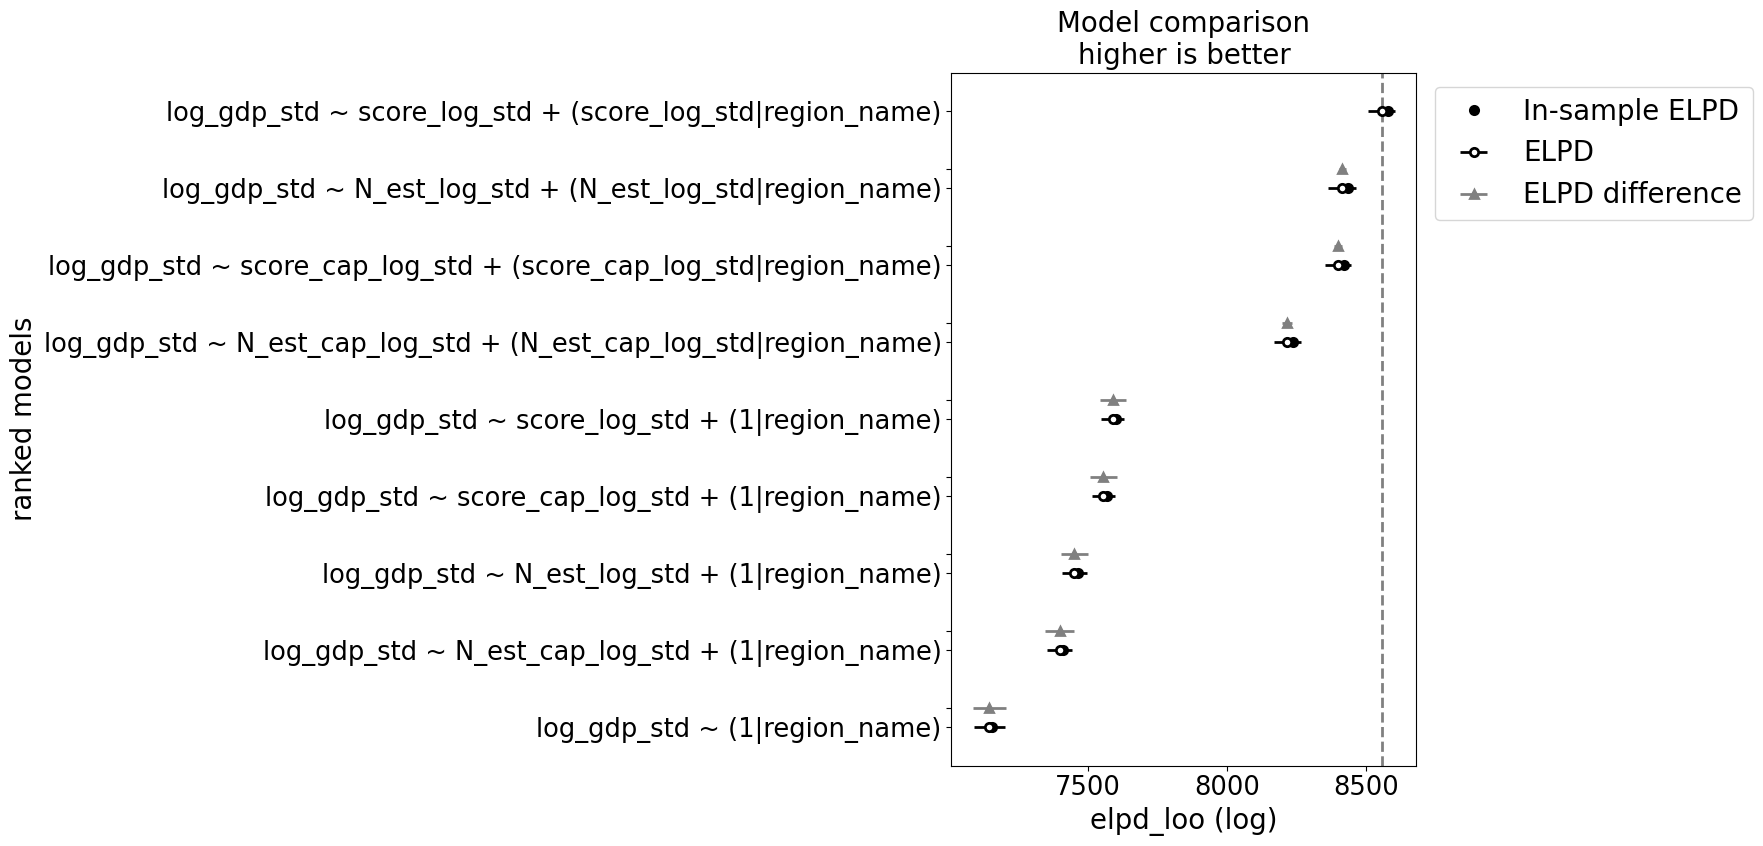

In [73]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);